In [1]:
import sys
#sys.path.insert(0,'./src/')
#simulator_path = "../covid_de/sim/" ##change simulatio path here 
sys.path.insert(0,'src/')
sys.path.insert(0, '../sib/')
simulator_path = "../covid_sim_giova/sim/" ##change simulatio path here 
sys.path.insert(0,simulator_path)

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import json, log, logging, loop_abm
from importlib import reload
import imp
from math import exp
import pickle
#sys.path.insert(0,'./src/loop_ranker')
from lib.mobilitysim import MobilitySimulator
import loop_mtpp
from mtpp_utils import contacts_cg


#logging
data_path = '../sib_test/results/MTPP/Isle_of_Wight/'

output_dir = data_path + "/output_pop20_site10/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


Log setup complete


### Mobility simulation

In [38]:
beta = 1.14 # from paper
country = 'GER'
with open(data_path + 'Isle_of_Wight_settings_pop10_site5.pk', 'rb') as fp:
    mob_kwargs = pickle.load(fp)

mob_kwargs["delta"] = 0.2554120904376099
T = 50
seed_mob = 1
seed = 1
t_unit = 24
t_res = 0.25 # drop contacts with a duration < t_res (in hours)
max_time = T * t_unit  
mob = MobilitySimulator(**mob_kwargs)
mob.verbose = True
out = mob.simulate(max_time=max_time, seed=seed_mob)
#contacts_df = pd.DataFrame(contacts_cg(mob, t_res, t_unit, first_filter = True),columns = ['i','j','t','deltat'])
N = mob.num_people 
#print(N)

Simulate mobility for 1200.00 time units... 

In [39]:
contacts_df = pd.DataFrame(contacts_cg(mob, t_res, t_unit, first_filter = True),columns = ['i','j','t','deltat'])

Check asymmetric contacts
All raw (i < j) contacts 1985768
0.0 %
25.18 %
50.36 %
75.54 %
Coarse-grained contacts 1981276


In [40]:
contacts_df = contacts_df.sort_values(by=["t","i","j"])

## Set testing and quarantine rules

In [41]:
#n_indiv=np.ceil(mob_kwargs['num_people_unscaled']/mob_kwargs['downsample_pop'])
n_seeds = {'expo': 2, 'iasy':2,'ipre':2} # select initial infected seeds
num_test_random = 0 #number of random tests per day
fraction_sym_obs = 0.5 #fraction of Symptomatic tested positive
initial_steps = 5 #starting time of intervention
delta_days = 1 # intervention every delta_days days (for the moment keep to 1)
#assert initial_steps % delta_days == 0
test_HH = False
quarantine_HH = True
adoption_fraction = 1.0

## Set the inference algorithm class

In [50]:
import sib, abm_utils, scipy

from loop_ranker import sib_rank, sib_drop_rank, greedy_rank, dotd_rank, mean_field_rank, tracing_rank, winbp_rank, winbp_prob0_rank
from tqdm.notebook import tqdm
from scipy.stats import gamma
sib.set_num_threads(6)

import matplotlib.pyplot as plt

mu = 1/12
prob_seed = 1/N
prob_sus = 0.5
pautoinf = 1e-10
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-6
fp_rate = 0.0
fn_rate = 0.0

rankers = {}
rankers["dotd"] = dotd_rank.DotdRanker()
'''

rankers["MF"] = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = mu,
                lamb = 1.0
                )
'''
rankers["tracing"] = tracing_rank.TracingRanker(
                 tau=5,
                 lamb=1.0
)

rankers["greedy"] = greedy_rank.GreedyRanker(
                 include_S = True,
                tau=10)


"""
rankers["winbp20prob0"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Uniform(1.0),
                                 prob_r = sib.Exponential(mu=mu),
                                 #prob_i = sib.PriorDiscrete(list(0.25 * abm_utils.gamma_pdf_array(T+1,6,2.5))),
                                 #prob_r = sib.PriorDiscrete(list(scipy.stats.gamma.sf(range(T+1), 10., scale=1.7452974337097158))),
                                 #prob_i = sib.Uniform(0.014),
                                 #prob_r = sib.Gamma(k = 10, mu = 1/1.7452974337097158),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 30,
                 maxit1 = 30,
                 damp0 = 0.5,
                 damp1 = 0.9,
                 tol = 1e-3,
                 memory_decay = 1e-2,
                 window_length = 20
)


rankers["no_intervention"] = None

rankers["winbp21_tau7"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=7
)

rankers["winbp21_tau0"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=0
)
"""

rankers["winbp21_uninf"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Uniform(1.0), 
                                prob_r = sib.Exponential(0.1), 
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=0
)



In [51]:
rankers

{'dotd': <loop_ranker.dotd_rank.DotdRanker at 0x7fc03010b4d0>,
 'tracing': <loop_ranker.tracing_rank.TracingRanker at 0x7fc030122090>,
 'greedy': <loop_ranker.greedy_rank.GreedyRanker at 0x7fc03010bd90>,
 'winbp21_uninf': <loop_ranker.winbp_prob0_rank.WinBPProb0Ranker at 0x7fc030122d50>}

In [52]:
ress = {}
for num_test_algo in [200]: #number of test per day by ranking
    for seed in [1]:
        print(num_test_algo, seed)
        for s in list(rankers.keys()):
            data = {"algo":s}
            if s== "no_intervention":
                    res_s = loop_mtpp.free_mtpp(mob,
                    country  = country,
                    beta = beta,
                    T = T,
                    seed=seed,
                    logger = logging.getLogger(f"iteration.{s}"),
                    data = data,
                    initial_counts = n_seeds,
                    name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                    output_dir = output_dir,
                     )
            else:
                    res_s = loop_mtpp.loop_mtpp(mob,
                    contacts_df,
                    rankers[s],
                    country  = country,
                    T = T,
                    seed=seed,
                    logger = logging.getLogger(f"iteration.{s}"),
                    data = data,
                    initial_steps = initial_steps, 
                    num_test_random = num_test_random,
                    num_test_algo = num_test_algo,
                    fraction_sym_obs = fraction_sym_obs,
                    initial_counts = n_seeds,
                    beta = beta,
                    test_HH = test_HH,
                    quarantine_HH = quarantine_HH,
                    name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                    output_dir = output_dir,
                    save_every_iter = 1,
                    adoption_fraction = adoption_fraction
                 )
            ress[s] = res_s    
        del res_s


200 1
DELTAAAAAA  0.2554120904376099
Starting with guys:  {'expo': [10569, 8248], 'iasy': [4355, 12084], 'ipre': [12801, 14142]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:0
iteration.dotd: INFO     number of unique contacts: 91364



[Reached max time: 24h (1d)]


iteration.dotd: INFO     True  : (S,I,R): (14188.0, 6.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.328, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 0 guys -> got 0 infected, 6 free as birds (+6)


t: 48.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:1
iteration.dotd: INFO     number of unique contacts: 102202



[Reached max time: 48h (2d)]


iteration.dotd: INFO     True  : (S,I,R): (14184.0, 10.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.374, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+4)


t: 72.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:2
iteration.dotd: INFO     number of unique contacts: 96912



[Reached max time: 72h (3d)]


iteration.dotd: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.475, prec100: 1, prec(1% of 14195): 0.01, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+3)


t: 96.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:3
iteration.dotd: INFO     number of unique contacts: 100654



[Reached max time: 96h (4d)]


iteration.dotd: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.442, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:4
iteration.dotd: INFO     number of unique contacts: 100872



[Reached max time: 120h (5d)]


iteration.dotd: INFO     True  : (S,I,R): (14163.0, 31.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.582, prec100: 1, prec(1% of 14195): 0.01, prec5%: 0.01
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 0 guys -> got 0 infected, 31 free as birds (+18)


t: 144.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     
observation-based inference algorithm starts now

iteration.dotd: INFO     time:5



[Reached max time: 144h (6d)]


iteration.dotd: INFO     number of unique contacts: 100852
iteration.dotd: INFO     True  : (S,I,R): (14068.0, 126.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.447, prec100: 0, prec(1% of 14190): 0.00, prec5%: 0.01
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (198,2,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 5 guys -> got 3 infected, 123 free as birds (+92)


t: 168.00 | 1200.00 hrs (50 d)
[Reached max time: 168h (7d)]


iteration.dotd: INFO     time:6
iteration.dotd: INFO     number of unique contacts: 99784
iteration.dotd: INFO     True  : (S,I,R): (13942.0, 252.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.467, prec100: 0, prec(1% of 14173): 0.00, prec5%: 0.01
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 17 guys -> got 12 infected, 235 free as birds (+112)


t: 192.00 | 1200.00 hrs (50 d)
[Reached max time: 192h (8d)]


iteration.dotd: INFO     time:7
iteration.dotd: INFO     number of unique contacts: 104198
iteration.dotd: INFO     True  : (S,I,R): (13665.0, 529.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.496, prec100: 0, prec(1% of 14142): 0.00, prec5%: 0.02
iteration.dotd: INFO     sym: 4, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 43 guys -> got 30 infected, 482 free as birds (+247)


t: 216.00 | 1200.00 hrs (50 d)
[Reached max time: 216h (9d)]


iteration.dotd: INFO     time:8
iteration.dotd: INFO     number of unique contacts: 98526
iteration.dotd: INFO     True  : (S,I,R): (13230.0, 964.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.491, prec100: 0, prec(1% of 14099): 0.00, prec5%: 0.05
iteration.dotd: INFO     sym: 9, results test algo (S,I,R): (190,10,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 62 guys -> got 57 infected, 860 free as birds (+378)


t: 240.00 | 1200.00 hrs (50 d)
[Reached max time: 240h (10d)]


iteration.dotd: INFO     time:9
iteration.dotd: INFO     number of unique contacts: 103640
iteration.dotd: INFO     True  : (S,I,R): (12588.0, 1606.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.498, prec100: 0, prec(1% of 14001): 0.00, prec5%: 0.08
iteration.dotd: INFO     sym: 20, results test algo (S,I,R): (178,22,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 134 guys -> got 120 infected, 1375 free as birds (+515)


t: 264.00 | 1200.00 hrs (50 d)
[Reached max time: 264h (11d)]


iteration.dotd: INFO     time:10
iteration.dotd: INFO     number of unique contacts: 94564
iteration.dotd: INFO     True  : (S,I,R): (11726.0, 2468.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.494, prec100: 0, prec(1% of 13852): 0.00, prec5%: 0.10
iteration.dotd: INFO     sym: 38, results test algo (S,I,R): (173,27,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 196 guys -> got 181 infected, 2046 free as birds (+671)


t: 288.00 | 1200.00 hrs (50 d)
[Reached max time: 288h (12d)]


iteration.dotd: INFO     time:11
iteration.dotd: INFO     number of unique contacts: 103994
iteration.dotd: INFO     True  : (S,I,R): (10498.0, 3696.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.490, prec100: 0, prec(1% of 13587): 0.00, prec5%: 0.17
iteration.dotd: INFO     sym: 70, results test algo (S,I,R): (153,47,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 353 guys -> got 334 infected, 2924 free as birds (+878)


t: 309.08 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     time:12
iteration.dotd: INFO     number of unique contacts: 100434
iteration.dotd: INFO     True  : (S,I,R): (9187.0, 5007.0, 0.0)
iteration.dotd: INFO     AUR_I : 0.498, prec100: 0, prec(1% of 13180): 0.00, prec5%: 0.25
iteration.dotd: INFO     sym: 119, results test algo (S,I,R): (134,66,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 552 guys -> got 517 infected, 3704 free as birds (+780)


t: 324.98 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



t: 336.00 | 1200.00 hrs (50 d)
[Reached max time: 336h (14d)]


iteration.dotd: INFO     time:13
iteration.dotd: INFO     number of unique contacts: 100618
iteration.dotd: INFO     True  : (S,I,R): (8042.0, 6151.0, 1.0)
iteration.dotd: INFO     AUR_I : 0.487, prec100: 0, prec(1% of 12651): 0.00, prec5%: 0.31
iteration.dotd: INFO     sym: 163, results test algo (S,I,R): (132,68,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 650 guys -> got 624 infected, 4208 free as birds (+504)


t: 360.00 | 1200.00 hrs (50 d)
[Reached max time: 360h (15d)]


iteration.dotd: INFO     time:14
iteration.dotd: INFO     number of unique contacts: 101338
iteration.dotd: INFO     True  : (S,I,R): (7101.0, 7091.0, 2.0)
iteration.dotd: INFO     AUR_I : 0.492, prec100: 0, prec(1% of 11925): 0.03, prec5%: 0.31
iteration.dotd: INFO     sym: 229, results test algo (S,I,R): (105,95,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 885 guys -> got 836 infected, 4299 free as birds (+91)


t: 375.30 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



t: 384.00 | 1200.00 hrs (50 d)
[Reached max time: 384h (16d)]


iteration.dotd: INFO     time:15
iteration.dotd: INFO     number of unique contacts: 105576
iteration.dotd: INFO     True  : (S,I,R): (6384.0, 7808.0, 2.0)
iteration.dotd: INFO     AUR_I : 0.495, prec100: 0, prec(1% of 11068): 0.00, prec5%: 0.36
iteration.dotd: INFO     sym: 289, results test algo (S,I,R): (106,94,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 930 guys -> got 849 infected, 4153 free as birds (-146)


t: 400.98 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



t: 408.00 | 1200.00 hrs (50 d)
[Reached max time: 408h (17d)]


iteration.dotd: INFO     time:16
iteration.dotd: INFO     number of unique contacts: 104602
iteration.dotd: INFO     True  : (S,I,R): (5797.0, 8395.0, 2.0)
iteration.dotd: INFO     AUR_I : 0.491, prec100: 0, prec(1% of 10164): 0.00, prec5%: 0.37
iteration.dotd: INFO     sym: 324, results test algo (S,I,R): (114,86,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 994 guys -> got 869 infected, 3853 free as birds (-300)


t: 426.74 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     time:17
iteration.dotd: INFO     number of unique contacts: 98434
iteration.dotd: INFO     True  : (S,I,R): (5275.0, 8915.0, 4.0)
iteration.dotd: INFO     AUR_I : 0.485, prec100: 0, prec(1% of 9148): 0.00, prec5%: 0.35
iteration.dotd: INFO     sym: 342, results test algo (S,I,R): (97,103,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 1011 guys -> got 857 infected, 3496 free as birds (-357)


t: 450.83 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     True  : (S,I,R): (4859.0, 9329.0, 6.0)
iteration.dotd: INFO     AUR_I : 0.503, prec100: 0, prec(1% of 8156): 0.00, prec5%: 0.36
iteration.dotd: INFO     sym: 281, results test algo (S,I,R): (108,92,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 787 guys -> got 681 infected, 3213 free as birds (-283)


t: 474.62 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     True  : (S,I,R): (4500.0, 9685.0, 9.0)
iteration.dotd: INFO     AUR_I : 0.485, prec100: 0, prec(1% of 7382): 0.00, prec5%: 0.33
iteration.dotd: INFO     sym: 280, results test algo (S,I,R): (107,93,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 752 guys -> got 654 infected, 2903 free as birds (-310)


t: 499.74 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     True  : (S,I,R): (4127.0, 10042.0, 25.0)
iteration.dotd: INFO     AUR_I : 0.488, prec100: 0, prec(1% of 6634): 0.00, prec5%: 0.34
iteration.dotd: INFO     sym: 216, results test algo (S,I,R): (103,97,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 581 guys -> got 488 infected, 2766 free as birds (-137)


t: 523.87 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     True  : (S,I,R): (3824.0, 10313.0, 57.0)
iteration.dotd: INFO     AUR_I : 0.493, prec100: 5, prec(1% of 6057): 0.00, prec5%: 0.35
iteration.dotd: INFO     sym: 187, results test algo (S,I,R): (93,107,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 543 guys -> got 475 infected, 2579 free as birds (-187)


t: 547.89 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     True  : (S,I,R): (3554.0, 10516.0, 124.0)
iteration.dotd: INFO     AUR_I : 0.489, prec100: 0, prec(1% of 5533): 0.00, prec5%: 0.34
iteration.dotd: INFO     sym: 183, results test algo (S,I,R): (104,96,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 502 guys -> got 423 infected, 2412 free as birds (-167)


t: 573.02 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.dotd: INFO     True  : (S,I,R): (3343.0, 10611.0, 240.0)
iteration.dotd: INFO     AUR_I : 0.477, prec100: 0, prec(1% of 5045): 0.00, prec5%: 0.27
iteration.dotd: INFO     sym: 180, results test algo (S,I,R): (107,92,1), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 457 guys -> got 379 infected, 2223 free as birds (-189)


t: 600.00 | 1200.00 hrs (50 d)
[Reached max time: 600h (25d)]


iteration.dotd: INFO     time:24
iteration.dotd: INFO     number of unique contacts: 100978
iteration.dotd: INFO     True  : (S,I,R): (3155.0, 10599.0, 440.0)
iteration.dotd: INFO     AUR_I : 0.462, prec100: 0, prec(1% of 4562): 0.00, prec5%: 0.23
iteration.dotd: INFO     sym: 163, results test algo (S,I,R): (101,99,0), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 467 guys -> got 397 infected, 1993 free as birds (-230)


t: 624.00 | 1200.00 hrs (50 d)
[Reached max time: 624h (26d)]


iteration.dotd: INFO     time:25
iteration.dotd: INFO     number of unique contacts: 99234
iteration.dotd: INFO     True  : (S,I,R): (3017.0, 10423.0, 754.0)
iteration.dotd: INFO     AUR_I : 0.467, prec100: 0, prec(1% of 4115): 0.00, prec5%: 0.23
iteration.dotd: INFO     sym: 133, results test algo (S,I,R): (100,99,1), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 380 guys -> got 327 infected, 1776 free as birds (-217)


t: 648.00 | 1200.00 hrs (50 d)
[Reached max time: 648h (27d)]


iteration.dotd: INFO     time:26
iteration.dotd: INFO     number of unique contacts: 105052
iteration.dotd: INFO     True  : (S,I,R): (2878.0, 10084.0, 1232.0)
iteration.dotd: INFO     AUR_I : 0.479, prec100: 0, prec(1% of 3751): 0.00, prec5%: 0.25
iteration.dotd: INFO     sym: 130, results test algo (S,I,R): (109,87,4), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 355 guys -> got 298 infected, 1576 free as birds (-200)


t: 672.00 | 1200.00 hrs (50 d)
[Reached max time: 672h (28d)]


iteration.dotd: INFO     time:27
iteration.dotd: INFO     number of unique contacts: 99142
iteration.dotd: INFO     True  : (S,I,R): (2771.0, 9566.0, 1857.0)
iteration.dotd: INFO     AUR_I : 0.483, prec100: 0, prec(1% of 3384): 0.00, prec5%: 0.13
iteration.dotd: INFO     sym: 88, results test algo (S,I,R): (104,86,10), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 294 guys -> got 244 infected, 1380 free as birds (-196)


t: 696.00 | 1200.00 hrs (50 d)
[Reached max time: 696h (29d)]


iteration.dotd: INFO     time:28
iteration.dotd: INFO     number of unique contacts: 96410
iteration.dotd: INFO     True  : (S,I,R): (2682.0, 8836.0, 2676.0)
iteration.dotd: INFO     AUR_I : 0.467, prec100: 0, prec(1% of 3081): 0.00, prec5%: 0.12
iteration.dotd: INFO     sym: 72, results test algo (S,I,R): (96,93,11), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 272 guys -> got 237 infected, 1159 free as birds (-221)


t: 720.00 | 1200.00 hrs (50 d)
[Reached max time: 720h (30d)]


iteration.dotd: INFO     time:29
iteration.dotd: INFO     number of unique contacts: 101084
iteration.dotd: INFO     True  : (S,I,R): (2611.0, 7971.0, 3612.0)
iteration.dotd: INFO     AUR_I : 0.466, prec100: 0, prec(1% of 2818): 0.00, prec5%: 0.06
iteration.dotd: INFO     sym: 59, results test algo (S,I,R): (110,75,15), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 230 guys -> got 194 infected, 963 free as birds (-196)


t: 744.00 | 1200.00 hrs (50 d)
[Reached max time: 744h (31d)]


iteration.dotd: INFO     time:30
iteration.dotd: INFO     number of unique contacts: 103750
iteration.dotd: INFO     True  : (S,I,R): (2546.0, 7091.0, 4557.0)
iteration.dotd: INFO     AUR_I : 0.469, prec100: 0, prec(1% of 2612): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 59, results test algo (S,I,R): (114,58,28), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 186 guys -> got 159 infected, 815 free as birds (-148)


t: 768.00 | 1200.00 hrs (50 d)
[Reached max time: 768h (32d)]


iteration.dotd: INFO     time:31
iteration.dotd: INFO     number of unique contacts: 102866
iteration.dotd: INFO     True  : (S,I,R): (2501.0, 6297.0, 5396.0)
iteration.dotd: INFO     AUR_I : 0.476, prec100: 0, prec(1% of 2383): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 53, results test algo (S,I,R): (103,72,25), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 187 guys -> got 161 infected, 655 free as birds (-160)


t: 792.00 | 1200.00 hrs (50 d)
[Reached max time: 792h (33d)]


iteration.dotd: INFO     time:32
iteration.dotd: INFO     number of unique contacts: 102072
iteration.dotd: INFO     True  : (S,I,R): (2467.0, 5487.0, 6240.0)
iteration.dotd: INFO     AUR_I : 0.457, prec100: 0, prec(1% of 2200): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 30, results test algo (S,I,R): (113,51,36), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 128 guys -> got 112 infected, 528 free as birds (-127)


t: 816.00 | 1200.00 hrs (50 d)
[Reached max time: 816h (34d)]


iteration.dotd: INFO     time:33
iteration.dotd: INFO     number of unique contacts: 102126
iteration.dotd: INFO     True  : (S,I,R): (2431.0, 4772.0, 6991.0)
iteration.dotd: INFO     AUR_I : 0.448, prec100: 0, prec(1% of 2042): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 24, results test algo (S,I,R): (121,46,33), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 108 guys -> got 91 infected, 433 free as birds (-95)


t: 840.00 | 1200.00 hrs (50 d)
[Reached max time: 840h (35d)]


iteration.dotd: INFO     time:34
iteration.dotd: INFO     number of unique contacts: 102570
iteration.dotd: INFO     True  : (S,I,R): (2404.0, 4088.0, 7702.0)
iteration.dotd: INFO     AUR_I : 0.445, prec100: 0, prec(1% of 1906): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 12, results test algo (S,I,R): (117,44,39), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 87 guys -> got 73 infected, 356 free as birds (-77)


t: 864.00 | 1200.00 hrs (50 d)
[Reached max time: 864h (36d)]


iteration.dotd: INFO     time:35
iteration.dotd: INFO     number of unique contacts: 100536
iteration.dotd: INFO     True  : (S,I,R): (2386.0, 3509.0, 8299.0)
iteration.dotd: INFO     AUR_I : 0.448, prec100: 0, prec(1% of 1809): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 17, results test algo (S,I,R): (140,28,32), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 65 guys -> got 54 infected, 298 free as birds (-58)


t: 888.00 | 1200.00 hrs (50 d)
[Reached max time: 888h (37d)]


iteration.dotd: INFO     time:36
iteration.dotd: INFO     number of unique contacts: 101654
iteration.dotd: INFO     True  : (S,I,R): (2365.0, 3021.0, 8808.0)
iteration.dotd: INFO     AUR_I : 0.449, prec100: 0, prec(1% of 1698): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 10, results test algo (S,I,R): (132,35,33), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 68 guys -> got 59 infected, 234 free as birds (-64)


t: 912.00 | 1200.00 hrs (50 d)
[Reached max time: 912h (38d)]


iteration.dotd: INFO     time:37
iteration.dotd: INFO     number of unique contacts: 101040
iteration.dotd: INFO     True  : (S,I,R): (2350.0, 2592.0, 9252.0)
iteration.dotd: INFO     AUR_I : 0.423, prec100: 0, prec(1% of 1609): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 12, results test algo (S,I,R): (143,26,31), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 61 guys -> got 48 infected, 188 free as birds (-46)


t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.dotd: INFO     time:38
iteration.dotd: INFO     number of unique contacts: 101164
iteration.dotd: INFO     True  : (S,I,R): (2338.0, 2230.0, 9626.0)
iteration.dotd: INFO     AUR_I : 0.431, prec100: 0, prec(1% of 1526): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 7, results test algo (S,I,R): (149,22,29), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 43 guys -> got 36 infected, 147 free as birds (-41)


t: 960.00 | 1200.00 hrs (50 d)
[Reached max time: 960h (40d)]


iteration.dotd: INFO     time:39
iteration.dotd: INFO     number of unique contacts: 100634
iteration.dotd: INFO     True  : (S,I,R): (2326.0, 1887.0, 9981.0)
iteration.dotd: INFO     AUR_I : 0.456, prec100: 0, prec(1% of 1461): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 6, results test algo (S,I,R): (157,16,27), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 33 guys -> got 30 infected, 118 free as birds (-29)


t: 984.00 | 1200.00 hrs (50 d)
[Reached max time: 984h (41d)]


iteration.dotd: INFO     time:40
iteration.dotd: INFO     number of unique contacts: 99014
iteration.dotd: INFO     True  : (S,I,R): (2313.0, 1589.0, 10292.0)
iteration.dotd: INFO     AUR_I : 0.479, prec100: 0, prec(1% of 1410): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 6, results test algo (S,I,R): (149,12,39), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 25 guys -> got 20 infected, 97 free as birds (-21)


t: 1008.00 | 1200.00 hrs (50 d)
[Reached max time: 1008h (42d)]


iteration.dotd: INFO     time:41
iteration.dotd: INFO     number of unique contacts: 105690
iteration.dotd: INFO     True  : (S,I,R): (2305.0, 1370.0, 10519.0)
iteration.dotd: INFO     AUR_I : 0.432, prec100: 0, prec(1% of 1337): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 6, results test algo (S,I,R): (156,19,25), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 35 guys -> got 31 infected, 69 free as birds (-28)


t: 1032.00 | 1200.00 hrs (50 d)
[Reached max time: 1032h (43d)]


iteration.dotd: INFO     time:42
iteration.dotd: INFO     number of unique contacts: 102172
iteration.dotd: INFO     True  : (S,I,R): (2302.0, 1139.0, 10753.0)
iteration.dotd: INFO     AUR_I : 0.422, prec100: 0, prec(1% of 1284): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 2, results test algo (S,I,R): (168,14,18), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 21 guys -> got 18 infected, 50 free as birds (-19)


t: 1056.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:43



[Reached max time: 1056h (44d)]


iteration.dotd: INFO     number of unique contacts: 103224
iteration.dotd: INFO     True  : (S,I,R): (2298.0, 953.0, 10943.0)
iteration.dotd: INFO     AUR_I : 0.362, prec100: 0, prec(1% of 1254): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 2, results test algo (S,I,R): (164,6,30), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 12 guys -> got 11 infected, 41 free as birds (-9)


t: 1080.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:44



[Reached max time: 1080h (45d)]


iteration.dotd: INFO     number of unique contacts: 95556
iteration.dotd: INFO     True  : (S,I,R): (2296.0, 796.0, 11102.0)
iteration.dotd: INFO     AUR_I : 0.355, prec100: 0, prec(1% of 1208): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 2, results test algo (S,I,R): (170,8,22), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 15 guys -> got 13 infected, 29 free as birds (-12)


t: 1104.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:45



[Reached max time: 1104h (46d)]


iteration.dotd: INFO     number of unique contacts: 102438
iteration.dotd: INFO     True  : (S,I,R): (2293.0, 664.0, 11237.0)
iteration.dotd: INFO     AUR_I : 0.371, prec100: 0, prec(1% of 1175): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 2, results test algo (S,I,R): (183,7,10), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 13 guys -> got 12 infected, 19 free as birds (-10)


t: 1128.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:46
iteration.dotd: INFO     number of unique contacts: 92514



[Reached max time: 1128h (47d)]


iteration.dotd: INFO     True  : (S,I,R): (2293.0, 551.0, 11350.0)
iteration.dotd: INFO     AUR_I : 0.359, prec100: 0, prec(1% of 1155): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (180,4,16), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 7 guys -> got 6 infected, 13 free as birds (-6)


t: 1152.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:47
iteration.dotd: INFO     number of unique contacts: 95682



[Reached max time: 1152h (48d)]


iteration.dotd: INFO     True  : (S,I,R): (2293.0, 472.0, 11429.0)
iteration.dotd: INFO     AUR_I : 0.304, prec100: 0, prec(1% of 1136): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (179,3,18), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 3 guys -> got 3 infected, 9 free as birds (-4)


t: 1176.00 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:48
iteration.dotd: INFO     number of unique contacts: 104460



[Reached max time: 1176h (49d)]


iteration.dotd: INFO     True  : (S,I,R): (2292.0, 394.0, 11508.0)
iteration.dotd: INFO     AUR_I : 0.390, prec100: 0, prec(1% of 1116): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 0, results test algo (S,I,R): (187,1,12), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 2 guys -> got 1 infected, 9 free as birds (+0)


t: 1199.89 | 1200.00 hrs (50 d)

iteration.dotd: INFO     time:49
iteration.dotd: INFO     number of unique contacts: 90996
iteration.dotd: INFO     True  : (S,I,R): (2288.0, 328.0, 11578.0)
iteration.dotd: INFO     AUR_I : 0.525, prec100: 0, prec(1% of 1099): 0.00, prec5%: 0.00
iteration.dotd: INFO     sym: 2, results test algo (S,I,R): (190,4,6), infected test random: 0/0
iteration.dotd: INFO     ...quarantining 7 guys -> got 7 infected, 6 free as birds (-3)


DELTAAAAAA  0.2554120904376099
Starting with guys:  {'expo': [10569, 8248], 'iasy': [4355, 12084], 'ipre': [12801, 14142]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.tracing: INFO     time:0
iteration.tracing: INFO     number of unique contacts: 91364



[Reached max time: 24h (1d)]


iteration.tracing: INFO     True  : (S,I,R): (14188.0, 6.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.328, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 0 guys -> got 0 infected, 6 free as birds (+6)


t: 48.00 | 1200.00 hrs (50 d)

iteration.tracing: INFO     time:1
iteration.tracing: INFO     number of unique contacts: 102202



[Reached max time: 48h (2d)]


iteration.tracing: INFO     True  : (S,I,R): (14184.0, 10.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.374, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+4)


t: 72.00 | 1200.00 hrs (50 d)

iteration.tracing: INFO     time:2
iteration.tracing: INFO     number of unique contacts: 96912



[Reached max time: 72h (3d)]


iteration.tracing: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.475, prec100: 1, prec(1% of 14195): 0.01, prec5%: 0.00
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+3)


t: 96.00 | 1200.00 hrs (50 d)

iteration.tracing: INFO     time:3
iteration.tracing: INFO     number of unique contacts: 100654



[Reached max time: 96h (4d)]


iteration.tracing: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.442, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.tracing: INFO     time:4
iteration.tracing: INFO     number of unique contacts: 100872



[Reached max time: 120h (5d)]


iteration.tracing: INFO     True  : (S,I,R): (14163.0, 31.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.582, prec100: 1, prec(1% of 14195): 0.01, prec5%: 0.01
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 0 guys -> got 0 infected, 31 free as birds (+18)


t: 144.00 | 1200.00 hrs (50 d)

iteration.tracing: INFO     
observation-based inference algorithm starts now

iteration.tracing: INFO     time:5



[Reached max time: 144h (6d)]


iteration.tracing: INFO     number of unique contacts: 100852
iteration.tracing: INFO     True  : (S,I,R): (14068.0, 126.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.472, prec100: 0, prec(1% of 14193): 0.00, prec5%: 0.01
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (199,1,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 2 guys -> got 1 infected, 125 free as birds (+94)


t: 168.00 | 1200.00 hrs (50 d)
[Reached max time: 168h (7d)]


iteration.tracing: INFO     time:6
iteration.tracing: INFO     number of unique contacts: 99784
iteration.tracing: INFO     True  : (S,I,R): (13944.0, 250.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.472, prec100: 0, prec(1% of 14183): 0.00, prec5%: 0.01
iteration.tracing: INFO     sym: 0, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 10 guys -> got 8 infected, 241 free as birds (+116)


t: 192.00 | 1200.00 hrs (50 d)
[Reached max time: 192h (8d)]


iteration.tracing: INFO     time:7
iteration.tracing: INFO     number of unique contacts: 104198
iteration.tracing: INFO     True  : (S,I,R): (13696.0, 498.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.468, prec100: 0, prec(1% of 13967): 0.00, prec5%: 0.02
iteration.tracing: INFO     sym: 4, results test algo (S,I,R): (141,59,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 230 guys -> got 150 infected, 338 free as birds (+97)


t: 216.00 | 1200.00 hrs (50 d)
[Reached max time: 216h (9d)]


iteration.tracing: INFO     time:8
iteration.tracing: INFO     number of unique contacts: 98526
iteration.tracing: INFO     True  : (S,I,R): (13387.0, 807.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.756, prec100: 0, prec(1% of 13638): 0.09, prec5%: 0.26
iteration.tracing: INFO     sym: 3, results test algo (S,I,R): (115,85,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 323 guys -> got 189 infected, 432 free as birds (+94)


t: 240.00 | 1200.00 hrs (50 d)
[Reached max time: 240h (10d)]


iteration.tracing: INFO     time:9
iteration.tracing: INFO     number of unique contacts: 103640
iteration.tracing: INFO     True  : (S,I,R): (12994.0, 1200.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.745, prec100: 9, prec(1% of 13230): 0.21, prec5%: 0.27
iteration.tracing: INFO     sym: 1, results test algo (S,I,R): (86,114,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 401 guys -> got 244 infected, 527 free as birds (+95)


t: 264.00 | 1200.00 hrs (50 d)
[Reached max time: 264h (11d)]


iteration.tracing: INFO     time:10
iteration.tracing: INFO     number of unique contacts: 94564
iteration.tracing: INFO     True  : (S,I,R): (12489.0, 1705.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.695, prec100: 1, prec(1% of 12966): 0.09, prec5%: 0.22
iteration.tracing: INFO     sym: 9, results test algo (S,I,R): (98,102,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 285 guys -> got 191 infected, 733 free as birds (+206)


t: 288.00 | 1200.00 hrs (50 d)
[Reached max time: 288h (12d)]


iteration.tracing: INFO     time:11
iteration.tracing: INFO     number of unique contacts: 103994
iteration.tracing: INFO     True  : (S,I,R): (11780.0, 2414.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.696, prec100: 0, prec(1% of 12721): 0.04, prec5%: 0.35
iteration.tracing: INFO     sym: 19, results test algo (S,I,R): (112,88,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 272 guys -> got 193 infected, 1164 free as birds (+431)


t: 309.38 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.tracing: INFO     True  : (S,I,R): (11054.0, 3140.0, 0.0)
iteration.tracing: INFO     AUR_I : 0.711, prec100: 0, prec(1% of 12334): 0.08, prec5%: 0.48
iteration.tracing: INFO     sym: 31, results test algo (S,I,R): (109,91,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 431 guys -> got 357 infected, 1457 free as birds (+293)


t: 330.43 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



t: 336.00 | 1200.00 hrs (50 d)
[Reached max time: 336h (14d)]


iteration.tracing: INFO     time:13
iteration.tracing: INFO     number of unique contacts: 100618
iteration.tracing: INFO     True  : (S,I,R): (10315.0, 3878.0, 1.0)
iteration.tracing: INFO     AUR_I : 0.723, prec100: 37, prec(1% of 11719): 0.44, prec5%: 0.55
iteration.tracing: INFO     sym: 35, results test algo (S,I,R): (36,164,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 591 guys -> got 456 infected, 1675 free as birds (+218)


t: 359.11 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.tracing: INFO     True  : (S,I,R): (9752.0, 4440.0, 2.0)
iteration.tracing: INFO     AUR_I : 0.714, prec100: 34, prec(1% of 11265): 0.39, prec5%: 0.59
iteration.tracing: INFO     sym: 61, results test algo (S,I,R): (57,143,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 530 guys -> got 434 infected, 1729 free as birds (+54)


t: 383.99 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iteration.tracing: INFO     True  : (S,I,R): (9294.0, 4898.0, 2.0)
iteration.tracing: INFO     AUR_I : 0.708, prec100: 41, prec(1% of 10645): 0.44, prec5%: 0.55
iteration.tracing: INFO     sym: 81, results test algo (S,I,R): (47,153,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 664 guys -> got 496 infected, 1639 free as birds (-90)


t: 408.00 | 1200.00 hrs (50 d)
[Reached max time: 408h (17d)]


iteration.tracing: INFO     time:16
iteration.tracing: INFO     number of unique contacts: 104602
iteration.tracing: INFO     True  : (S,I,R): (8905.0, 5287.0, 2.0)
iteration.tracing: INFO     AUR_I : 0.681, prec100: 41, prec(1% of 10012): 0.41, prec5%: 0.46
iteration.tracing: INFO     sym: 116, results test algo (S,I,R): (43,157,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 695 guys -> got 515 infected, 1468 free as birds (-171)


t: 432.00 | 1200.00 hrs (50 d)
[Reached max time: 432h (18d)]


iteration.tracing: INFO     time:17
iteration.tracing: INFO     number of unique contacts: 98434
iteration.tracing: INFO     True  : (S,I,R): (8587.0, 5603.0, 4.0)
iteration.tracing: INFO     AUR_I : 0.666, prec100: 9, prec(1% of 9424): 0.09, prec5%: 0.35
iteration.tracing: INFO     sym: 119, results test algo (S,I,R): (82,118,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 560 guys -> got 399 infected, 1326 free as birds (-142)


t: 456.00 | 1200.00 hrs (50 d)
[Reached max time: 456h (19d)]


iteration.tracing: INFO     time:18
iteration.tracing: INFO     number of unique contacts: 97830
iteration.tracing: INFO     True  : (S,I,R): (8295.0, 5893.0, 6.0)
iteration.tracing: INFO     AUR_I : 0.646, prec100: 0, prec(1% of 8991): 0.00, prec5%: 0.28
iteration.tracing: INFO     sym: 109, results test algo (S,I,R): (125,75,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 423 guys -> got 275 infected, 1300 free as birds (-26)


t: 480.00 | 1200.00 hrs (50 d)
[Reached max time: 480h (20d)]


iteration.tracing: INFO     time:19
iteration.tracing: INFO     number of unique contacts: 99866
iteration.tracing: INFO     True  : (S,I,R): (7974.0, 6211.0, 9.0)
iteration.tracing: INFO     AUR_I : 0.623, prec100: 0, prec(1% of 8634): 0.00, prec5%: 0.26
iteration.tracing: INFO     sym: 102, results test algo (S,I,R): (142,58,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 348 guys -> got 220 infected, 1359 free as birds (+59)


t: 504.00 | 1200.00 hrs (50 d)
[Reached max time: 504h (21d)]


iteration.tracing: INFO     time:20
iteration.tracing: INFO     number of unique contacts: 99008
iteration.tracing: INFO     True  : (S,I,R): (7679.0, 6491.0, 24.0)
iteration.tracing: INFO     AUR_I : 0.596, prec100: 0, prec(1% of 8259): 0.00, prec5%: 0.28
iteration.tracing: INFO     sym: 96, results test algo (S,I,R): (138,62,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 343 guys -> got 227 infected, 1394 free as birds (+35)


t: 528.00 | 1200.00 hrs (50 d)
[Reached max time: 528h (22d)]


iteration.tracing: INFO     time:21
iteration.tracing: INFO     number of unique contacts: 102988
iteration.tracing: INFO     True  : (S,I,R): (7342.0, 6796.0, 56.0)
iteration.tracing: INFO     AUR_I : 0.565, prec100: 0, prec(1% of 7935): 0.00, prec5%: 0.26
iteration.tracing: INFO     sym: 94, results test algo (S,I,R): (135,65,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 324 guys -> got 224 infected, 1471 free as birds (+77)


t: 552.00 | 1200.00 hrs (50 d)
[Reached max time: 552h (23d)]


iteration.tracing: INFO     time:22
iteration.tracing: INFO     number of unique contacts: 102376
iteration.tracing: INFO     True  : (S,I,R): (7101.0, 6982.0, 111.0)
iteration.tracing: INFO     AUR_I : 0.566, prec100: 0, prec(1% of 7646): 0.00, prec5%: 0.23
iteration.tracing: INFO     sym: 100, results test algo (S,I,R): (153,47,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 292 guys -> got 208 infected, 1478 free as birds (+7)


t: 576.00 | 1200.00 hrs (50 d)
[Reached max time: 576h (24d)]


iteration.tracing: INFO     time:23
iteration.tracing: INFO     number of unique contacts: 103962
iteration.tracing: INFO     True  : (S,I,R): (6866.0, 7128.0, 200.0)
iteration.tracing: INFO     AUR_I : 0.554, prec100: 0, prec(1% of 7361): 0.00, prec5%: 0.23
iteration.tracing: INFO     sym: 123, results test algo (S,I,R): (143,57,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 327 guys -> got 246 infected, 1442 free as birds (-36)


t: 600.00 | 1200.00 hrs (50 d)
[Reached max time: 600h (25d)]


iteration.tracing: INFO     time:24
iteration.tracing: INFO     number of unique contacts: 100978
iteration.tracing: INFO     True  : (S,I,R): (6630.0, 7217.0, 347.0)
iteration.tracing: INFO     AUR_I : 0.565, prec100: 0, prec(1% of 7051): 0.00, prec5%: 0.21
iteration.tracing: INFO     sym: 124, results test algo (S,I,R): (145,55,0), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 307 guys -> got 239 infected, 1415 free as birds (-27)


t: 624.00 | 1200.00 hrs (50 d)
[Reached max time: 624h (26d)]


iteration.tracing: INFO     time:25
iteration.tracing: INFO     number of unique contacts: 99234
iteration.tracing: INFO     True  : (S,I,R): (6403.0, 7218.0, 573.0)
iteration.tracing: INFO     AUR_I : 0.559, prec100: 0, prec(1% of 6734): 0.00, prec5%: 0.21
iteration.tracing: INFO     sym: 90, results test algo (S,I,R): (142,57,1), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 265 guys -> got 207 infected, 1406 free as birds (-9)


t: 648.00 | 1200.00 hrs (50 d)
[Reached max time: 648h (27d)]


iteration.tracing: INFO     time:26
iteration.tracing: INFO     number of unique contacts: 105052
iteration.tracing: INFO     True  : (S,I,R): (6162.0, 7166.0, 866.0)
iteration.tracing: INFO     AUR_I : 0.557, prec100: 0, prec(1% of 6460): 0.00, prec5%: 0.25
iteration.tracing: INFO     sym: 99, results test algo (S,I,R): (129,70,1), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 289 guys -> got 223 infected, 1409 free as birds (+3)


t: 672.00 | 1200.00 hrs (50 d)
[Reached max time: 672h (28d)]


iteration.tracing: INFO     time:27
iteration.tracing: INFO     number of unique contacts: 99142
iteration.tracing: INFO     True  : (S,I,R): (5958.0, 6971.0, 1265.0)
iteration.tracing: INFO     AUR_I : 0.550, prec100: 0, prec(1% of 6131): 0.00, prec5%: 0.24
iteration.tracing: INFO     sym: 107, results test algo (S,I,R): (115,81,4), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 331 guys -> got 267 infected, 1325 free as birds (-84)


t: 696.00 | 1200.00 hrs (50 d)
[Reached max time: 696h (29d)]


iteration.tracing: INFO     time:28
iteration.tracing: INFO     number of unique contacts: 96410
iteration.tracing: INFO     True  : (S,I,R): (5760.0, 6660.0, 1774.0)
iteration.tracing: INFO     AUR_I : 0.555, prec100: 0, prec(1% of 5814): 0.00, prec5%: 0.26
iteration.tracing: INFO     sym: 97, results test algo (S,I,R): (117,78,5), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 300 guys -> got 235 infected, 1273 free as birds (-52)


t: 720.00 | 1200.00 hrs (50 d)
[Reached max time: 720h (30d)]


iteration.tracing: INFO     time:29
iteration.tracing: INFO     number of unique contacts: 101084
iteration.tracing: INFO     True  : (S,I,R): (5564.0, 6296.0, 2334.0)
iteration.tracing: INFO     AUR_I : 0.544, prec100: 0, prec(1% of 5515): 0.00, prec5%: 0.20
iteration.tracing: INFO     sym: 70, results test algo (S,I,R): (117,81,2), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 247 guys -> got 204 infected, 1231 free as birds (-42)


t: 744.00 | 1200.00 hrs (50 d)
[Reached max time: 744h (31d)]


iteration.tracing: INFO     time:30
iteration.tracing: INFO     number of unique contacts: 103750
iteration.tracing: INFO     True  : (S,I,R): (5376.0, 5917.0, 2901.0)
iteration.tracing: INFO     AUR_I : 0.558, prec100: 0, prec(1% of 5275): 0.00, prec5%: 0.17
iteration.tracing: INFO     sym: 86, results test algo (S,I,R): (129,69,2), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 271 guys -> got 213 infected, 1175 free as birds (-56)


t: 768.00 | 1200.00 hrs (50 d)
[Reached max time: 768h (32d)]


iteration.tracing: INFO     time:31
iteration.tracing: INFO     number of unique contacts: 102866
iteration.tracing: INFO     True  : (S,I,R): (5212.0, 5560.0, 3422.0)
iteration.tracing: INFO     AUR_I : 0.561, prec100: 0, prec(1% of 5016): 0.00, prec5%: 0.20
iteration.tracing: INFO     sym: 71, results test algo (S,I,R): (134,61,5), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 222 guys -> got 172 infected, 1142 free as birds (-33)


t: 792.00 | 1200.00 hrs (50 d)
[Reached max time: 792h (33d)]


iteration.tracing: INFO     time:32
iteration.tracing: INFO     number of unique contacts: 102072
iteration.tracing: INFO     True  : (S,I,R): (5053.0, 5202.0, 3939.0)
iteration.tracing: INFO     AUR_I : 0.549, prec100: 0, prec(1% of 4774): 0.00, prec5%: 0.18
iteration.tracing: INFO     sym: 73, results test algo (S,I,R): (124,71,5), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 239 guys -> got 197 infected, 1075 free as birds (-67)


t: 816.00 | 1200.00 hrs (50 d)
[Reached max time: 816h (34d)]


iteration.tracing: INFO     time:33
iteration.tracing: INFO     number of unique contacts: 102126
iteration.tracing: INFO     True  : (S,I,R): (4947.0, 4820.0, 4427.0)
iteration.tracing: INFO     AUR_I : 0.549, prec100: 0, prec(1% of 4542): 0.00, prec5%: 0.14
iteration.tracing: INFO     sym: 63, results test algo (S,I,R): (127,66,7), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 212 guys -> got 167 infected, 977 free as birds (-98)


t: 840.00 | 1200.00 hrs (50 d)
[Reached max time: 840h (35d)]


iteration.tracing: INFO     time:34
iteration.tracing: INFO     number of unique contacts: 102570
iteration.tracing: INFO     True  : (S,I,R): (4810.0, 4518.0, 4866.0)
iteration.tracing: INFO     AUR_I : 0.532, prec100: 0, prec(1% of 4327): 0.00, prec5%: 0.16
iteration.tracing: INFO     sym: 70, results test algo (S,I,R): (130,63,7), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 222 guys -> got 179 infected, 913 free as birds (-64)


t: 864.00 | 1200.00 hrs (50 d)
[Reached max time: 864h (36d)]


iteration.tracing: INFO     time:35
iteration.tracing: INFO     number of unique contacts: 100536
iteration.tracing: INFO     True  : (S,I,R): (4685.0, 4247.0, 5262.0)
iteration.tracing: INFO     AUR_I : 0.525, prec100: 0, prec(1% of 4078): 0.00, prec5%: 0.13
iteration.tracing: INFO     sym: 60, results test algo (S,I,R): (118,74,8), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 221 guys -> got 172 infected, 839 free as birds (-74)


t: 888.00 | 1200.00 hrs (50 d)
[Reached max time: 888h (37d)]


iteration.tracing: INFO     time:36
iteration.tracing: INFO     number of unique contacts: 101654
iteration.tracing: INFO     True  : (S,I,R): (4609.0, 3972.0, 5613.0)
iteration.tracing: INFO     AUR_I : 0.513, prec100: 0, prec(1% of 3864): 0.00, prec5%: 0.08
iteration.tracing: INFO     sym: 39, results test algo (S,I,R): (134,62,4), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 173 guys -> got 140 infected, 758 free as birds (-81)


t: 912.00 | 1200.00 hrs (50 d)
[Reached max time: 912h (38d)]


iteration.tracing: INFO     time:37
iteration.tracing: INFO     number of unique contacts: 101040
iteration.tracing: INFO     True  : (S,I,R): (4533.0, 3715.0, 5946.0)
iteration.tracing: INFO     AUR_I : 0.503, prec100: 0, prec(1% of 3710): 0.00, prec5%: 0.07
iteration.tracing: INFO     sym: 49, results test algo (S,I,R): (143,52,5), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 172 guys -> got 134 infected, 681 free as birds (-77)


t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.tracing: INFO     time:38
iteration.tracing: INFO     number of unique contacts: 101164
iteration.tracing: INFO     True  : (S,I,R): (4458.0, 3467.0, 6269.0)
iteration.tracing: INFO     AUR_I : 0.514, prec100: 0, prec(1% of 3531): 0.00, prec5%: 0.04
iteration.tracing: INFO     sym: 44, results test algo (S,I,R): (146,48,6), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 160 guys -> got 127 infected, 612 free as birds (-69)


t: 960.00 | 1200.00 hrs (50 d)
[Reached max time: 960h (40d)]


iteration.tracing: INFO     time:39
iteration.tracing: INFO     number of unique contacts: 100634
iteration.tracing: INFO     True  : (S,I,R): (4387.0, 3243.0, 6564.0)
iteration.tracing: INFO     AUR_I : 0.520, prec100: 0, prec(1% of 3378): 0.00, prec5%: 0.04
iteration.tracing: INFO     sym: 39, results test algo (S,I,R): (143,48,9), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 137 guys -> got 114 infected, 541 free as birds (-71)


t: 984.00 | 1200.00 hrs (50 d)
[Reached max time: 984h (41d)]


iteration.tracing: INFO     time:40
iteration.tracing: INFO     number of unique contacts: 99014
iteration.tracing: INFO     True  : (S,I,R): (4320.0, 3034.0, 6840.0)
iteration.tracing: INFO     AUR_I : 0.506, prec100: 0, prec(1% of 3244): 0.00, prec5%: 0.01
iteration.tracing: INFO     sym: 37, results test algo (S,I,R): (154,42,4), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 123 guys -> got 99 infected, 497 free as birds (-44)


t: 1008.00 | 1200.00 hrs (50 d)
[Reached max time: 1008h (42d)]


iteration.tracing: INFO     time:41
iteration.tracing: INFO     number of unique contacts: 105690
iteration.tracing: INFO     True  : (S,I,R): (4254.0, 2828.0, 7112.0)
iteration.tracing: INFO     AUR_I : 0.489, prec100: 0, prec(1% of 3113): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 18, results test algo (S,I,R): (149,41,10), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 93 guys -> got 73 infected, 464 free as birds (-33)


t: 1032.00 | 1200.00 hrs (50 d)
[Reached max time: 1032h (43d)]


iteration.tracing: INFO     time:42
iteration.tracing: INFO     number of unique contacts: 102172
iteration.tracing: INFO     True  : (S,I,R): (4210.0, 2622.0, 7362.0)
iteration.tracing: INFO     AUR_I : 0.489, prec100: 0, prec(1% of 3022): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 33, results test algo (S,I,R): (154,33,13), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 111 guys -> got 90 infected, 398 free as birds (-66)


t: 1056.00 | 1200.00 hrs (50 d)
[Reached max time: 1056h (44d)]


iteration.tracing: INFO     time:43
iteration.tracing: INFO     number of unique contacts: 103224
iteration.tracing: INFO     True  : (S,I,R): (4172.0, 2417.0, 7605.0)
iteration.tracing: INFO     AUR_I : 0.464, prec100: 0, prec(1% of 2899): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 20, results test algo (S,I,R): (156,34,10), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 85 guys -> got 70 infected, 351 free as birds (-47)


t: 1080.00 | 1200.00 hrs (50 d)
[Reached max time: 1080h (45d)]


iteration.tracing: INFO     time:44
iteration.tracing: INFO     number of unique contacts: 95556
iteration.tracing: INFO     True  : (S,I,R): (4131.0, 2226.0, 7837.0)
iteration.tracing: INFO     AUR_I : 0.460, prec100: 0, prec(1% of 2799): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 16, results test algo (S,I,R): (155,36,9), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 82 guys -> got 72 infected, 304 free as birds (-47)


t: 1104.00 | 1200.00 hrs (50 d)
[Reached max time: 1104h (46d)]


iteration.tracing: INFO     time:45
iteration.tracing: INFO     number of unique contacts: 102438
iteration.tracing: INFO     True  : (S,I,R): (4109.0, 2045.0, 8040.0)
iteration.tracing: INFO     AUR_I : 0.441, prec100: 0, prec(1% of 2734): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 20, results test algo (S,I,R): (169,20,11), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 62 guys -> got 49 infected, 266 free as birds (-38)


t: 1128.00 | 1200.00 hrs (50 d)
[Reached max time: 1128h (47d)]


iteration.tracing: INFO     time:46
iteration.tracing: INFO     number of unique contacts: 92514
iteration.tracing: INFO     True  : (S,I,R): (4080.0, 1850.0, 8264.0)
iteration.tracing: INFO     AUR_I : 0.406, prec100: 0, prec(1% of 2657): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 21, results test algo (S,I,R): (170,22,8), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 74 guys -> got 53 infected, 229 free as birds (-37)


t: 1152.00 | 1200.00 hrs (50 d)
[Reached max time: 1152h (48d)]


iteration.tracing: INFO     time:47
iteration.tracing: INFO     number of unique contacts: 95682
iteration.tracing: INFO     True  : (S,I,R): (4060.0, 1667.0, 8467.0)
iteration.tracing: INFO     AUR_I : 0.410, prec100: 0, prec(1% of 2578): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 12, results test algo (S,I,R): (170,22,8), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 51 guys -> got 39 infected, 194 free as birds (-35)


t: 1176.00 | 1200.00 hrs (50 d)
[Reached max time: 1176h (49d)]


iteration.tracing: INFO     time:48
iteration.tracing: INFO     number of unique contacts: 104460
iteration.tracing: INFO     True  : (S,I,R): (4040.0, 1506.0, 8648.0)
iteration.tracing: INFO     AUR_I : 0.398, prec100: 0, prec(1% of 2533): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 11, results test algo (S,I,R): (171,13,16), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 36 guys -> got 30 infected, 174 free as birds (-20)


t: 1199.98 | 1200.00 hrs (50 d)

iteration.tracing: INFO     time:49
iteration.tracing: INFO     number of unique contacts: 90996
iteration.tracing: INFO     True  : (S,I,R): (4029.0, 1332.0, 8833.0)
iteration.tracing: INFO     AUR_I : 0.378, prec100: 0, prec(1% of 2479): 0.00, prec5%: 0.00
iteration.tracing: INFO     sym: 6, results test algo (S,I,R): (180,15,5), infected test random: 0/0
iteration.tracing: INFO     ...quarantining 31 guys -> got 26 infected, 146 free as birds (-28)


DELTAAAAAA  0.2554120904376099
Starting with guys:  {'expo': [10569, 8248], 'iasy': [4355, 12084], 'ipre': [12801, 14142]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:0
iteration.greedy: INFO     number of unique contacts: 91364



[Reached max time: 24h (1d)]
all contacts: 91364
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (14188.0, 6.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.333, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 6 free as birds (+6)


t: 48.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:1
iteration.greedy: INFO     number of unique contacts: 102202



[Reached max time: 48h (2d)]
all contacts: 193566
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (14184.0, 10.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.327, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+4)


t: 72.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:2
iteration.greedy: INFO     number of unique contacts: 96912



[Reached max time: 72h (3d)]
all contacts: 290478
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.396, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+3)


t: 96.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:3
iteration.greedy: INFO     number of unique contacts: 100654



[Reached max time: 96h (4d)]
all contacts: 391132
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.390, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:4
iteration.greedy: INFO     number of unique contacts: 100872



[Reached max time: 120h (5d)]
all contacts: 492004
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (14163.0, 31.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.434, prec100: 1, prec(1% of 14195): 0.01, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 31 free as birds (+18)


t: 144.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     
observation-based inference algorithm starts now

iteration.greedy: INFO     time:5



[Reached max time: 144h (6d)]


iteration.greedy: INFO     number of unique contacts: 100852


all contacts: 592856
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (14068.0, 126.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.473, prec100: 0, prec(1% of 14193): 0.00, prec5%: 0.01
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (199,1,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 2 guys -> got 1 infected, 125 free as birds (+94)


t: 168.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:6



[Reached max time: 168h (7d)]


iteration.greedy: INFO     number of unique contacts: 99784


all contacts: 692624
all contacts cut: 30


iteration.greedy: INFO     True  : (S,I,R): (13944.0, 250.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.472, prec100: 0, prec(1% of 14183): 0.00, prec5%: 0.01
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 10 guys -> got 8 infected, 241 free as birds (+116)


t: 192.00 | 1200.00 hrs (50 d)
[Reached max time: 192h (8d)]


iteration.greedy: INFO     time:7
iteration.greedy: INFO     number of unique contacts: 104198


all contacts: 796632
all contacts cut: 398


iteration.greedy: INFO     True  : (S,I,R): (13696.0, 498.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.474, prec100: 0, prec(1% of 13958): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (139,61,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 239 guys -> got 152 infected, 336 free as birds (+95)


t: 216.00 | 1200.00 hrs (50 d)
[Reached max time: 216h (9d)]


iteration.greedy: INFO     time:8
iteration.greedy: INFO     number of unique contacts: 98526


all contacts: 888576
all contacts cut: 16770


iteration.greedy: INFO     True  : (S,I,R): (13387.0, 807.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.775, prec100: 4, prec(1% of 13558): 0.11, prec5%: 0.25
iteration.greedy: INFO     sym: 3, results test algo (S,I,R): (96,104,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 394 guys -> got 219 infected, 400 free as birds (+64)


t: 240.00 | 1200.00 hrs (50 d)
[Reached max time: 240h (10d)]


iteration.greedy: INFO     time:9
iteration.greedy: INFO     number of unique contacts: 103640


all contacts: 976064
all contacts cut: 38473


iteration.greedy: INFO     True  : (S,I,R): (13026.0, 1168.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.767, prec100: 14, prec(1% of 13120): 0.18, prec5%: 0.20
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (66,134,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 431 guys -> got 252 infected, 433 free as birds (+33)


t: 264.00 | 1200.00 hrs (50 d)
[Reached max time: 264h (11d)]


iteration.greedy: INFO     time:10
iteration.greedy: INFO     number of unique contacts: 94564


all contacts: 1049766
all contacts cut: 47017


iteration.greedy: INFO     True  : (S,I,R): (12569.0, 1625.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.727, prec100: 0, prec(1% of 12905): 0.02, prec5%: 0.18
iteration.greedy: INFO     sym: 7, results test algo (S,I,R): (107,93,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 231 guys -> got 156 infected, 612 free as birds (+179)


t: 288.00 | 1200.00 hrs (50 d)
[Reached max time: 288h (12d)]


iteration.greedy: INFO     time:11
iteration.greedy: INFO     number of unique contacts: 103994


all contacts: 77660
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (11944.0, 2250.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.509, prec100: 0, prec(1% of 12840): 0.00, prec5%: 0.05
iteration.greedy: INFO     sym: 18, results test algo (S,I,R): (184,16,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 94 guys -> got 78 infected, 1075 free as birds (+463)


t: 312.00 | 1200.00 hrs (50 d)
[Reached max time: 312h (13d)]


iteration.greedy: INFO     time:12
iteration.greedy: INFO     number of unique contacts: 100434


all contacts: 150814
all contacts cut: 1135


iteration.greedy: INFO     True  : (S,I,R): (11190.0, 3004.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.560, prec100: 34, prec(1% of 12200): 0.38, prec5%: 0.30
iteration.greedy: INFO     sym: 27, results test algo (S,I,R): (30,170,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 674 guys -> got 490 infected, 1269 free as birds (+194)


t: 332.03 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



all contacts: 210482
all contacts cut: 10997


iteration.greedy: INFO     True  : (S,I,R): (10482.0, 3711.0, 1.0)
iteration.greedy: INFO     AUR_I : 0.642, prec100: 53, prec(1% of 11581): 0.57, prec5%: 0.51
iteration.greedy: INFO     sym: 32, results test algo (S,I,R): (29,171,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 611 guys -> got 428 infected, 1473 free as birds (+204)


t: 359.58 | 1200.00 hrs (50 d)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



all contacts: 262182
all contacts cut: 13124


iteration.greedy: INFO     True  : (S,I,R): (9833.0, 4359.0, 2.0)
iteration.greedy: INFO     AUR_I : 0.665, prec100: 52, prec(1% of 11033): 0.54, prec5%: 0.54
iteration.greedy: INFO     sym: 58, results test algo (S,I,R): (40,160,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 623 guys -> got 474 infected, 1540 free as birds (+67)


t: 384.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:15



[Reached max time: 384h (16d)]


iteration.greedy: INFO     number of unique contacts: 105576


all contacts: 303062
all contacts cut: 19968


iteration.greedy: INFO     True  : (S,I,R): (9336.0, 4856.0, 2.0)
iteration.greedy: INFO     AUR_I : 0.680, prec100: 51, prec(1% of 10360): 0.52, prec5%: 0.55
iteration.greedy: INFO     sym: 67, results test algo (S,I,R): (31,169,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 684 guys -> got 489 infected, 1480 free as birds (-60)


t: 408.00 | 1200.00 hrs (50 d)
[Reached max time: 408h (17d)]


iteration.greedy: INFO     time:16
iteration.greedy: INFO     number of unique contacts: 104602


all contacts: 336412
all contacts cut: 28395


iteration.greedy: INFO     True  : (S,I,R): (8980.0, 5212.0, 2.0)
iteration.greedy: INFO     AUR_I : 0.681, prec100: 36, prec(1% of 9755): 0.34, prec5%: 0.44
iteration.greedy: INFO     sym: 93, results test algo (S,I,R): (47,153,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 628 guys -> got 440 infected, 1340 free as birds (-140)


t: 432.00 | 1200.00 hrs (50 d)
[Reached max time: 432h (18d)]


iteration.greedy: INFO     time:17
iteration.greedy: INFO     number of unique contacts: 98434


all contacts: 364202
all contacts cut: 33927


iteration.greedy: INFO     True  : (S,I,R): (8636.0, 5554.0, 4.0)
iteration.greedy: INFO     AUR_I : 0.654, prec100: 8, prec(1% of 9267): 0.09, prec5%: 0.33
iteration.greedy: INFO     sym: 88, results test algo (S,I,R): (82,118,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 471 guys -> got 312 infected, 1288 free as birds (-52)


t: 456.00 | 1200.00 hrs (50 d)
[Reached max time: 456h (19d)]


iteration.greedy: INFO     time:18
iteration.greedy: INFO     number of unique contacts: 97830


all contacts: 387730
all contacts cut: 37939


iteration.greedy: INFO     True  : (S,I,R): (8362.0, 5826.0, 6.0)
iteration.greedy: INFO     AUR_I : 0.651, prec100: 0, prec(1% of 8902): 0.00, prec5%: 0.27
iteration.greedy: INFO     sym: 90, results test algo (S,I,R): (103,97,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 373 guys -> got 268 infected, 1249 free as birds (-39)


t: 480.00 | 1200.00 hrs (50 d)
[Reached max time: 480h (20d)]


iteration.greedy: INFO     time:19
iteration.greedy: INFO     number of unique contacts: 99866


all contacts: 410562
all contacts cut: 42475


iteration.greedy: INFO     True  : (S,I,R): (8042.0, 6143.0, 9.0)
iteration.greedy: INFO     AUR_I : 0.633, prec100: 0, prec(1% of 8519): 0.00, prec5%: 0.24
iteration.greedy: INFO     sym: 102, results test algo (S,I,R): (112,88,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 410 guys -> got 277 infected, 1241 free as birds (-8)


t: 504.00 | 1200.00 hrs (50 d)
[Reached max time: 504h (21d)]


iteration.greedy: INFO     time:20
iteration.greedy: INFO     number of unique contacts: 99008


all contacts: 430532
all contacts cut: 48049


iteration.greedy: INFO     True  : (S,I,R): (7786.0, 6384.0, 24.0)
iteration.greedy: INFO     AUR_I : 0.628, prec100: 0, prec(1% of 8197): 0.00, prec5%: 0.25
iteration.greedy: INFO     sym: 83, results test algo (S,I,R): (135,65,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 272 guys -> got 196 infected, 1267 free as birds (+26)


t: 528.00 | 1200.00 hrs (50 d)
[Reached max time: 528h (22d)]


iteration.greedy: INFO     time:21
iteration.greedy: INFO     number of unique contacts: 102988


all contacts: 449490
all contacts cut: 51679


iteration.greedy: INFO     True  : (S,I,R): (7522.0, 6616.0, 56.0)
iteration.greedy: INFO     AUR_I : 0.614, prec100: 0, prec(1% of 7899): 0.00, prec5%: 0.22
iteration.greedy: INFO     sym: 84, results test algo (S,I,R): (115,85,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 302 guys -> got 229 infected, 1275 free as birds (+8)


t: 552.00 | 1200.00 hrs (50 d)
[Reached max time: 552h (23d)]


iteration.greedy: INFO     time:22
iteration.greedy: INFO     number of unique contacts: 102376


all contacts: 17462
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (7283.0, 6801.0, 110.0)
iteration.greedy: INFO     AUR_I : 0.472, prec100: 0, prec(1% of 7689): 0.00, prec5%: 0.09
iteration.greedy: INFO     sym: 84, results test algo (S,I,R): (172,28,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 210 guys -> got 145 infected, 1350 free as birds (+75)


t: 576.00 | 1200.00 hrs (50 d)
[Reached max time: 576h (24d)]


iteration.greedy: INFO     time:23
iteration.greedy: INFO     number of unique contacts: 103962


all contacts: 33504
all contacts cut: 389


iteration.greedy: INFO     True  : (S,I,R): (7044.0, 6952.0, 198.0)
iteration.greedy: INFO     AUR_I : 0.463, prec100: 0, prec(1% of 7409): 0.00, prec5%: 0.12
iteration.greedy: INFO     sym: 102, results test algo (S,I,R): (127,72,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 307 guys -> got 232 infected, 1339 free as birds (-11)


t: 600.00 | 1200.00 hrs (50 d)
[Reached max time: 600h (25d)]


iteration.greedy: INFO     time:24
iteration.greedy: INFO     number of unique contacts: 100978


all contacts: 47958
all contacts cut: 1220


iteration.greedy: INFO     True  : (S,I,R): (6841.0, 7007.0, 346.0)
iteration.greedy: INFO     AUR_I : 0.474, prec100: 0, prec(1% of 7071): 0.00, prec5%: 0.18
iteration.greedy: INFO     sym: 100, results test algo (S,I,R): (111,89,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 337 guys -> got 255 infected, 1278 free as birds (-61)


t: 624.00 | 1200.00 hrs (50 d)
[Reached max time: 624h (26d)]


iteration.greedy: INFO     time:25
iteration.greedy: INFO     number of unique contacts: 99234


all contacts: 61684
all contacts cut: 2574


iteration.greedy: INFO     True  : (S,I,R): (6634.0, 6987.0, 573.0)
iteration.greedy: INFO     AUR_I : 0.503, prec100: 0, prec(1% of 6766): 0.00, prec5%: 0.19
iteration.greedy: INFO     sym: 95, results test algo (S,I,R): (128,72,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 290 guys -> got 229 infected, 1237 free as birds (-41)


t: 648.00 | 1200.00 hrs (50 d)
[Reached max time: 648h (27d)]


iteration.greedy: INFO     time:26
iteration.greedy: INFO     number of unique contacts: 105052


all contacts: 75206
all contacts cut: 3745


iteration.greedy: INFO     True  : (S,I,R): (6463.0, 6880.0, 851.0)
iteration.greedy: INFO     AUR_I : 0.539, prec100: 0, prec(1% of 6457): 0.00, prec5%: 0.23
iteration.greedy: INFO     sym: 75, results test algo (S,I,R): (115,84,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 278 guys -> got 211 infected, 1188 free as birds (-49)


t: 672.00 | 1200.00 hrs (50 d)
[Reached max time: 672h (28d)]


iteration.greedy: INFO     time:27
iteration.greedy: INFO     number of unique contacts: 99142


all contacts: 87384
all contacts cut: 5257


iteration.greedy: INFO     True  : (S,I,R): (6242.0, 6723.0, 1229.0)
iteration.greedy: INFO     AUR_I : 0.548, prec100: 0, prec(1% of 6178): 0.00, prec5%: 0.22
iteration.greedy: INFO     sym: 77, results test algo (S,I,R): (116,82,2), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 278 guys -> got 211 infected, 1177 free as birds (-11)


t: 696.00 | 1200.00 hrs (50 d)
[Reached max time: 696h (29d)]


iteration.greedy: INFO     time:28
iteration.greedy: INFO     number of unique contacts: 96410


all contacts: 98510
all contacts cut: 6983


iteration.greedy: INFO     True  : (S,I,R): (6027.0, 6436.0, 1731.0)
iteration.greedy: INFO     AUR_I : 0.569, prec100: 0, prec(1% of 5875): 0.00, prec5%: 0.24
iteration.greedy: INFO     sym: 66, results test algo (S,I,R): (98,99,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 282 guys -> got 219 infected, 1152 free as birds (-25)


t: 720.00 | 1200.00 hrs (50 d)
[Reached max time: 720h (30d)]


iteration.greedy: INFO     time:29
iteration.greedy: INFO     number of unique contacts: 101084


all contacts: 109140
all contacts cut: 9004


iteration.greedy: INFO     True  : (S,I,R): (5832.0, 6106.0, 2256.0)
iteration.greedy: INFO     AUR_I : 0.578, prec100: 0, prec(1% of 5586): 0.00, prec5%: 0.24
iteration.greedy: INFO     sym: 75, results test algo (S,I,R): (102,95,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 308 guys -> got 244 infected, 1080 free as birds (-72)


t: 744.00 | 1200.00 hrs (50 d)
[Reached max time: 744h (31d)]


iteration.greedy: INFO     time:30
iteration.greedy: INFO     number of unique contacts: 103750


all contacts: 118446
all contacts cut: 11432


iteration.greedy: INFO     True  : (S,I,R): (5689.0, 5684.0, 2821.0)
iteration.greedy: INFO     AUR_I : 0.592, prec100: 0, prec(1% of 5294): 0.00, prec5%: 0.22
iteration.greedy: INFO     sym: 57, results test algo (S,I,R): (106,87,7), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 253 guys -> got 197 infected, 992 free as birds (-88)


t: 768.00 | 1200.00 hrs (50 d)
[Reached max time: 768h (32d)]


iteration.greedy: INFO     time:31
iteration.greedy: INFO     number of unique contacts: 102866


all contacts: 127062
all contacts cut: 13365


iteration.greedy: INFO     True  : (S,I,R): (5554.0, 5323.0, 3317.0)
iteration.greedy: INFO     AUR_I : 0.598, prec100: 0, prec(1% of 5026): 0.00, prec5%: 0.22
iteration.greedy: INFO     sym: 54, results test algo (S,I,R): (97,99,4), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 255 guys -> got 210 infected, 901 free as birds (-91)


t: 792.00 | 1200.00 hrs (50 d)
[Reached max time: 792h (33d)]


iteration.greedy: INFO     time:32
iteration.greedy: INFO     number of unique contacts: 102072


all contacts: 134786
all contacts cut: 15195


iteration.greedy: INFO     True  : (S,I,R): (5453.0, 4888.0, 3853.0)
iteration.greedy: INFO     AUR_I : 0.605, prec100: 0, prec(1% of 4783): 0.00, prec5%: 0.18
iteration.greedy: INFO     sym: 61, results test algo (S,I,R): (116,81,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 249 guys -> got 193 infected, 782 free as birds (-119)


t: 816.00 | 1200.00 hrs (50 d)
[Reached max time: 816h (34d)]


iteration.greedy: INFO     time:33
iteration.greedy: INFO     number of unique contacts: 102126


all contacts: 6804
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (5327.0, 4512.0, 4355.0)
iteration.greedy: INFO     AUR_I : 0.485, prec100: 0, prec(1% of 4620): 0.00, prec5%: 0.03
iteration.greedy: INFO     sym: 65, results test algo (S,I,R): (171,28,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 170 guys -> got 128 infected, 744 free as birds (-38)


t: 840.00 | 1200.00 hrs (50 d)
[Reached max time: 840h (35d)]


iteration.greedy: INFO     time:34
iteration.greedy: INFO     number of unique contacts: 102570


all contacts: 13450
all contacts cut: 162


iteration.greedy: INFO     True  : (S,I,R): (5223.0, 4183.0, 4788.0)
iteration.greedy: INFO     AUR_I : 0.479, prec100: 0, prec(1% of 4422): 0.00, prec5%: 0.01
iteration.greedy: INFO     sym: 63, results test algo (S,I,R): (149,46,5), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 187 guys -> got 138 infected, 695 free as birds (-49)


t: 864.00 | 1200.00 hrs (50 d)
[Reached max time: 864h (36d)]


iteration.greedy: INFO     time:35
iteration.greedy: INFO     number of unique contacts: 100536


all contacts: 19898
all contacts cut: 446


iteration.greedy: INFO     True  : (S,I,R): (5102.0, 3885.0, 5207.0)
iteration.greedy: INFO     AUR_I : 0.477, prec100: 0, prec(1% of 4227): 0.00, prec5%: 0.01
iteration.greedy: INFO     sym: 38, results test algo (S,I,R): (139,51,10), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 155 guys -> got 121 infected, 664 free as birds (-31)


t: 888.00 | 1200.00 hrs (50 d)
[Reached max time: 888h (37d)]


iteration.greedy: INFO     time:36
iteration.greedy: INFO     number of unique contacts: 101654


all contacts: 25832
all contacts cut: 837


iteration.greedy: INFO     True  : (S,I,R): (5010.0, 3644.0, 5540.0)
iteration.greedy: INFO     AUR_I : 0.467, prec100: 0, prec(1% of 4030): 0.00, prec5%: 0.08
iteration.greedy: INFO     sym: 40, results test algo (S,I,R): (121,73,6), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 186 guys -> got 153 infected, 580 free as birds (-84)


t: 912.00 | 1200.00 hrs (50 d)
[Reached max time: 912h (38d)]


iteration.greedy: INFO     time:37
iteration.greedy: INFO     number of unique contacts: 101040


all contacts: 31208
all contacts cut: 1464


iteration.greedy: INFO     True  : (S,I,R): (4927.0, 3372.0, 5895.0)
iteration.greedy: INFO     AUR_I : 0.487, prec100: 0, prec(1% of 3861): 0.00, prec5%: 0.09
iteration.greedy: INFO     sym: 30, results test algo (S,I,R): (139,57,4), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 152 guys -> got 119 infected, 527 free as birds (-53)


t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.greedy: INFO     time:38
iteration.greedy: INFO     number of unique contacts: 101164


all contacts: 36294
all contacts cut: 1958


iteration.greedy: INFO     True  : (S,I,R): (4864.0, 3157.0, 6173.0)
iteration.greedy: INFO     AUR_I : 0.479, prec100: 0, prec(1% of 3692): 0.00, prec5%: 0.08
iteration.greedy: INFO     sym: 25, results test algo (S,I,R): (124,68,8), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 150 guys -> got 119 infected, 455 free as birds (-72)


t: 960.00 | 1200.00 hrs (50 d)
[Reached max time: 960h (40d)]


iteration.greedy: INFO     time:39
iteration.greedy: INFO     number of unique contacts: 100634


all contacts: 41088
all contacts cut: 2564


iteration.greedy: INFO     True  : (S,I,R): (4816.0, 2945.0, 6433.0)
iteration.greedy: INFO     AUR_I : 0.495, prec100: 0, prec(1% of 3526): 0.00, prec5%: 0.05
iteration.greedy: INFO     sym: 25, results test algo (S,I,R): (121,68,11), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 157 guys -> got 120 infected, 366 free as birds (-89)


t: 984.00 | 1200.00 hrs (50 d)
[Reached max time: 984h (41d)]


iteration.greedy: INFO     time:40
iteration.greedy: INFO     number of unique contacts: 99014


all contacts: 49832
all contacts cut: 3661


iteration.greedy: INFO     True  : (S,I,R): (4729.0, 2536.0, 6929.0)
iteration.greedy: INFO     AUR_I : 0.504, prec100: 0, prec(1% of 3286): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 13, results test algo (S,I,R): (152,38,10), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 77 guys -> got 64 infected, 268 free as birds (-45)


t: 1032.00 | 1200.00 hrs (50 d)
[Reached max time: 1032h (43d)]


iteration.greedy: INFO     time:42
iteration.greedy: INFO     number of unique contacts: 102172


all contacts: 53952
all contacts cut: 4004


iteration.greedy: INFO     True  : (S,I,R): (4677.0, 2343.0, 7174.0)
iteration.greedy: INFO     AUR_I : 0.507, prec100: 0, prec(1% of 3192): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 10, results test algo (S,I,R): (148,36,16), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 81 guys -> got 65 infected, 241 free as birds (-27)


t: 1056.00 | 1200.00 hrs (50 d)
[Reached max time: 1056h (44d)]


iteration.greedy: INFO     time:43
iteration.greedy: INFO     number of unique contacts: 103224


all contacts: 57836
all contacts cut: 4349


iteration.greedy: INFO     True  : (S,I,R): (4648.0, 2182.0, 7364.0)
iteration.greedy: INFO     AUR_I : 0.525, prec100: 0, prec(1% of 3103): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 12, results test algo (S,I,R): (156,32,12), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 77 guys -> got 63 infected, 199 free as birds (-42)


t: 1080.00 | 1200.00 hrs (50 d)
[Reached max time: 1080h (45d)]


iteration.greedy: INFO     time:44
iteration.greedy: INFO     number of unique contacts: 95556


all contacts: 3630
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (4632.0, 1993.0, 7569.0)
iteration.greedy: INFO     AUR_I : 0.423, prec100: 0, prec(1% of 3050): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 15, results test algo (S,I,R): (187,10,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 43 guys -> got 32 infected, 171 free as birds (-28)


t: 1104.00 | 1200.00 hrs (50 d)
[Reached max time: 1104h (46d)]


iteration.greedy: INFO     time:45
iteration.greedy: INFO     number of unique contacts: 102438


all contacts: 7252
all contacts cut: 33


iteration.greedy: INFO     True  : (S,I,R): (4616.0, 1796.0, 7782.0)
iteration.greedy: INFO     AUR_I : 0.448, prec100: 0, prec(1% of 3021): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 16, results test algo (S,I,R): (196,2,2), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 26 guys -> got 20 infected, 154 free as birds (-17)


t: 1128.00 | 1200.00 hrs (50 d)
[Reached max time: 1128h (47d)]


iteration.greedy: INFO     time:46
iteration.greedy: INFO     number of unique contacts: 92514


all contacts: 10696
all contacts cut: 61


iteration.greedy: INFO     True  : (S,I,R): (4599.0, 1623.0, 7972.0)
iteration.greedy: INFO     AUR_I : 0.452, prec100: 0, prec(1% of 2992): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 9, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 18 guys -> got 13 infected, 150 free as birds (-4)


t: 1152.00 | 1200.00 hrs (50 d)
[Reached max time: 1152h (48d)]


iteration.greedy: INFO     time:47
iteration.greedy: INFO     number of unique contacts: 95682


all contacts: 14216
all contacts cut: 98


iteration.greedy: INFO     True  : (S,I,R): (4579.0, 1477.0, 8138.0)
iteration.greedy: INFO     AUR_I : 0.443, prec100: 0, prec(1% of 2967): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 13, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 32 guys -> got 26 infected, 133 free as birds (-17)


t: 1176.00 | 1200.00 hrs (50 d)
[Reached max time: 1176h (49d)]


iteration.greedy: INFO     time:48
iteration.greedy: INFO     number of unique contacts: 104460


all contacts: 17736
all contacts cut: 183


iteration.greedy: INFO     True  : (S,I,R): (4564.0, 1316.0, 8314.0)
iteration.greedy: INFO     AUR_I : 0.422, prec100: 0, prec(1% of 2928): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (189,10,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 24 guys -> got 18 infected, 125 free as birds (-8)


t: 1199.97 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:49
iteration.greedy: INFO     number of unique contacts: 90996


all contacts: 21084
all contacts cut: 250


iteration.greedy: INFO     True  : (S,I,R): (4560.0, 1160.0, 8474.0)
iteration.greedy: INFO     AUR_I : 0.427, prec100: 0, prec(1% of 2909): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 6, results test algo (S,I,R): (190,8,2), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 21 guys -> got 18 infected, 108 free as birds (-17)


DELTAAAAAA  0.2554120904376099
Starting with guys:  {'expo': [10569, 8248], 'iasy': [4355, 12084], 'ipre': [12801, 14142]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     time:0
iteration.winbp21_uninf: INFO     number of unique contacts: 91364



[Reached max time: 24h (1d)]


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14193.0, 0.9, 0.1), seeds: 1.0, ll: -9838.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (14188.0, 6.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.368, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 0 guys -> got 0 infected, 6 free as birds (+6)


t: 48.00 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     time:1
iteration.winbp21_uninf: INFO     number of unique contacts: 102202



[Reached max time: 48h (2d)]


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14192.6, 1.2, 0.2), seeds: 1.0, ll: -9838.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (14184.0, 10.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.511, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+4)


t: 72.00 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     time:2
iteration.winbp21_uninf: INFO     number of unique contacts: 96912



[Reached max time: 72h (3d)]


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14191.8, 1.8, 0.4), seeds: 1.0, ll: -9838.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.557, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+3)


t: 96.00 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     time:3
iteration.winbp21_uninf: INFO     number of unique contacts: 100654



[Reached max time: 96h (4d)]


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14190.6, 2.7, 0.7), seeds: 1.0, ll: -9838.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (14181.0, 13.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.567, prec100: 0, prec(1% of 14195): 0.00, prec5%: 0.00
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     time:4
iteration.winbp21_uninf: INFO     number of unique contacts: 100872



[Reached max time: 120h (5d)]


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14188.2, 4.6, 1.2), seeds: 1.0, ll: -9838.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (14163.0, 31.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.613, prec100: 2, prec(1% of 14195): 0.01, prec5%: 0.01
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 0 guys -> got 0 infected, 31 free as birds (+18)


t: 144.00 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     
observation-based inference algorithm starts now

iteration.winbp21_uninf: INFO     time:5



[Reached max time: 144h (6d)]


iteration.winbp21_uninf: INFO     number of unique contacts: 100852


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14183.5, 8.4, 2.1), seeds: 1.0, ll: -9838.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (14068.0, 126.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.766, prec100: 0, prec(1% of 14151): 0.00, prec5%: 0.04
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (190,10,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 44 guys -> got 18 infected, 108 free as birds (+77)


t: 168.00 | 1200.00 hrs (50 d)
[Reached max time: 168h (7d)]


iteration.winbp21_uninf: INFO     time:6
iteration.winbp21_uninf: INFO     number of unique contacts: 99784


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (14093.3, 87.2, 13.5), seeds: 1.3, ll: -9680.6
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13955.0, 239.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.822, prec100: 0, prec(1% of 13869): 0.02, prec5%: 0.05
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (121,79,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 282 guys -> got 130 infected, 85 free as birds (-23)


t: 192.00 | 1200.00 hrs (50 d)
[Reached max time: 192h (8d)]


iteration.winbp21_uninf: INFO     time:7
iteration.winbp21_uninf: INFO     number of unique contacts: 104198


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13774.3, 356.6, 63.1), seeds: 4.1, ll: -10330.5
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13843.0, 351.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.727, prec100: 0, prec(1% of 13709): 0.00, prec5%: 0.02
iteration.winbp21_uninf: INFO     sym: 4, results test algo (S,I,R): (149,51,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 167 guys -> got 79 infected, 63 free as birds (-22)


t: 216.00 | 1200.00 hrs (50 d)
[Reached max time: 216h (9d)]


iteration.winbp21_uninf: INFO     time:8
iteration.winbp21_uninf: INFO     number of unique contacts: 98526


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13631.3, 462.9, 99.8), seeds: 4.2, ll: -10495.8
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13753.0, 441.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.736, prec100: 0, prec(1% of 13655): 0.00, prec5%: 0.02
iteration.winbp21_uninf: INFO     sym: 2, results test algo (S,I,R): (185,15,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 51 guys -> got 26 infected, 61 free as birds (-2)


t: 240.00 | 1200.00 hrs (50 d)
[Reached max time: 240h (10d)]


iteration.winbp21_uninf: INFO     time:9
iteration.winbp21_uninf: INFO     number of unique contacts: 103640


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13682.4, 395.2, 116.3), seeds: 5.2, ll: -10573.7
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13676.0, 518.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.793, prec100: 0, prec(1% of 13630): 0.00, prec5%: 0.03
iteration.winbp21_uninf: INFO     sym: 1, results test algo (S,I,R): (193,7,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 23 guys -> got 15 infected, 73 free as birds (+12)


t: 264.00 | 1200.00 hrs (50 d)
[Reached max time: 264h (11d)]


iteration.winbp21_uninf: INFO     time:10
iteration.winbp21_uninf: INFO     number of unique contacts: 94564


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13702.9, 355.0, 136.1), seeds: 5.6, ll: -10485.2
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13548.0, 646.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.771, prec100: 0, prec(1% of 13603): 0.00, prec5%: 0.04
iteration.winbp21_uninf: INFO     sym: 3, results test algo (S,I,R): (191,9,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 32 guys -> got 22 infected, 134 free as birds (+61)


t: 288.00 | 1200.00 hrs (50 d)
[Reached max time: 288h (12d)]


iteration.winbp21_uninf: INFO     time:11
iteration.winbp21_uninf: INFO     number of unique contacts: 103994


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13682.9, 348.3, 162.8), seeds: 4.5, ll: -10246.4
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13398.0, 796.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.755, prec100: 0, prec(1% of 13483): 0.00, prec5%: 0.07
iteration.winbp21_uninf: INFO     sym: 0, results test algo (S,I,R): (169,31,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 113 guys -> got 50 infected, 199 free as birds (+65)


t: 312.00 | 1200.00 hrs (50 d)
[Reached max time: 312h (13d)]


iteration.winbp21_uninf: INFO     time:12
iteration.winbp21_uninf: INFO     number of unique contacts: 100434


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13327.3, 608.5, 258.3), seeds: 6.0, ll: -10803.2
iteration.winbp21_uninf: INFO     True  : (S,I,R): (13216.0, 978.0, 0.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.735, prec100: 0, prec(1% of 13369): 0.00, prec5%: 0.08
iteration.winbp21_uninf: INFO     sym: 5, results test algo (S,I,R): (169,31,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 125 guys -> got 59 infected, 301 free as birds (+102)


t: 336.00 | 1200.00 hrs (50 d)
[Reached max time: 336h (14d)]


iteration.winbp21_uninf: INFO     time:13
iteration.winbp21_uninf: INFO     number of unique contacts: 100618


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13369.1, 563.0, 261.9), seeds: 5.7, ll: -10157.2
iteration.winbp21_uninf: INFO     True  : (S,I,R): (12932.0, 1261.0, 1.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.735, prec100: 0, prec(1% of 13114): 0.01, prec5%: 0.11
iteration.winbp21_uninf: INFO     sym: 8, results test algo (S,I,R): (130,70,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 266 guys -> got 157 infected, 366 free as birds (+65)


t: 360.00 | 1200.00 hrs (50 d)
[Reached max time: 360h (15d)]


iteration.winbp21_uninf: INFO     time:14
iteration.winbp21_uninf: INFO     number of unique contacts: 101338


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (13037.8, 804.4, 351.8), seeds: 5.3, ll: -11360.2
iteration.winbp21_uninf: INFO     True  : (S,I,R): (12682.0, 1510.0, 2.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.706, prec100: 0, prec(1% of 12821): 0.00, prec5%: 0.09
iteration.winbp21_uninf: INFO     sym: 11, results test algo (S,I,R): (123,77,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 299 guys -> got 161 infected, 427 free as birds (+61)


t: 384.00 | 1200.00 hrs (50 d)
[Reached max time: 384h (16d)]


iteration.winbp21_uninf: INFO     time:15
iteration.winbp21_uninf: INFO     number of unique contacts: 105576


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (12727.2, 1026.2, 440.6), seeds: 5.9, ll: -11124.3
iteration.winbp21_uninf: INFO     True  : (S,I,R): (12419.0, 1773.0, 2.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.711, prec100: 0, prec(1% of 12624): 0.00, prec5%: 0.12
iteration.winbp21_uninf: INFO     sym: 16, results test algo (S,I,R): (145,55,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 204 guys -> got 126 infected, 532 free as birds (+105)


t: 408.00 | 1200.00 hrs (50 d)
[Reached max time: 408h (17d)]


iteration.winbp21_uninf: INFO     time:16
iteration.winbp21_uninf: INFO     number of unique contacts: 104602


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (12519.8, 1138.4, 535.9), seeds: 6.0, ll: -11085.9
iteration.winbp21_uninf: INFO     True  : (S,I,R): (12177.0, 2015.0, 2.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.728, prec100: 0, prec(1% of 12300): 0.05, prec5%: 0.17
iteration.winbp21_uninf: INFO     sym: 24, results test algo (S,I,R): (110,90,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 342 guys -> got 167 infected, 562 free as birds (+30)


t: 432.00 | 1200.00 hrs (50 d)
[Reached max time: 432h (18d)]


iteration.winbp21_uninf: INFO     time:17
iteration.winbp21_uninf: INFO     number of unique contacts: 98434


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (12190.3, 1333.0, 670.7), seeds: 5.4, ll: -12971.7
iteration.winbp21_uninf: INFO     True  : (S,I,R): (11931.0, 2259.0, 4.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.719, prec100: 0, prec(1% of 11959): 0.01, prec5%: 0.19
iteration.winbp21_uninf: INFO     sym: 26, results test algo (S,I,R): (119,81,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 341 guys -> got 166 infected, 595 free as birds (+33)


t: 456.00 | 1200.00 hrs (50 d)
[Reached max time: 456h (19d)]


iteration.winbp21_uninf: INFO     time:18
iteration.winbp21_uninf: INFO     number of unique contacts: 97830


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (11895.0, 1497.3, 801.7), seeds: 6.8, ll: -12847.2
iteration.winbp21_uninf: INFO     True  : (S,I,R): (11676.0, 2512.0, 6.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.725, prec100: 0, prec(1% of 11590): 0.01, prec5%: 0.18
iteration.winbp21_uninf: INFO     sym: 38, results test algo (S,I,R): (109,91,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 410 guys -> got 197 infected, 604 free as birds (+9)


t: 480.00 | 1200.00 hrs (50 d)
[Reached max time: 480h (20d)]


iteration.winbp21_uninf: INFO     time:19
iteration.winbp21_uninf: INFO     number of unique contacts: 99866


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (11589.1, 1666.1, 938.7), seeds: 6.3, ll: -12277.1
iteration.winbp21_uninf: INFO     True  : (S,I,R): (11381.0, 2804.0, 9.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.718, prec100: 0, prec(1% of 11236): 0.00, prec5%: 0.19
iteration.winbp21_uninf: INFO     sym: 36, results test algo (S,I,R): (120,80,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 335 guys -> got 166 infected, 659 free as birds (+55)


t: 504.00 | 1200.00 hrs (50 d)
[Reached max time: 504h (21d)]


iteration.winbp21_uninf: INFO     time:20
iteration.winbp21_uninf: INFO     number of unique contacts: 99008


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (11385.2, 1726.1, 1082.7), seeds: 7.5, ll: -12300.5
iteration.winbp21_uninf: INFO     True  : (S,I,R): (11150.0, 3021.0, 23.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.712, prec100: 0, prec(1% of 10893): 0.00, prec5%: 0.15
iteration.winbp21_uninf: INFO     sym: 45, results test algo (S,I,R): (115,85,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 357 guys -> got 185 infected, 664 free as birds (+5)


t: 528.00 | 1200.00 hrs (50 d)
[Reached max time: 528h (22d)]


iteration.winbp21_uninf: INFO     time:21
iteration.winbp21_uninf: INFO     number of unique contacts: 102988


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.9048333698381238


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (11149.0, 1810.4, 1234.6), seeds: 8.4, ll: -19093.7
iteration.winbp21_uninf: INFO     True  : (S,I,R): (10862.0, 3285.0, 47.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.697, prec100: 0, prec(1% of 10630): 0.00, prec5%: 0.18
iteration.winbp21_uninf: INFO     sym: 39, results test algo (S,I,R): (147,53,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 258 guys -> got 139 infected, 767 free as birds (+103)


t: 552.00 | 1200.00 hrs (50 d)
[Reached max time: 552h (23d)]


iteration.winbp21_uninf: INFO     time:22
iteration.winbp21_uninf: INFO     number of unique contacts: 102376


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.2094655356899897


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (10959.5, 1838.2, 1396.3), seeds: 12.8, ll: -20009.9
iteration.winbp21_uninf: INFO     True  : (S,I,R): (10595.0, 3503.0, 96.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.699, prec100: 0, prec(1% of 10338): 0.00, prec5%: 0.19
iteration.winbp21_uninf: INFO     sym: 49, results test algo (S,I,R): (126,74,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 304 guys -> got 182 infected, 813 free as birds (+46)


t: 576.00 | 1200.00 hrs (50 d)
[Reached max time: 576h (24d)]


iteration.winbp21_uninf: INFO     time:23
iteration.winbp21_uninf: INFO     number of unique contacts: 103962


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.7739008301935004


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (10747.5, 1903.9, 1542.6), seeds: 17.0, ll: -19349.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (10349.0, 3702.0, 143.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.693, prec100: 1, prec(1% of 9975): 0.00, prec5%: 0.18
iteration.winbp21_uninf: INFO     sym: 56, results test algo (S,I,R): (100,100,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 380 guys -> got 216 infected, 802 free as birds (-11)


t: 600.00 | 1200.00 hrs (50 d)
[Reached max time: 600h (25d)]


iteration.winbp21_uninf: INFO     time:24
iteration.winbp21_uninf: INFO     number of unique contacts: 100978


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2.7098335222498493


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (10441.4, 2028.0, 1724.6), seeds: 26.8, ll: -19824.7
iteration.winbp21_uninf: INFO     True  : (S,I,R): (10123.0, 3847.0, 224.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.683, prec100: 0, prec(1% of 9652): 0.00, prec5%: 0.18
iteration.winbp21_uninf: INFO     sym: 66, results test algo (S,I,R): (123,76,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 344 guys -> got 205 infected, 789 free as birds (-13)


t: 624.00 | 1200.00 hrs (50 d)
[Reached max time: 624h (26d)]


iteration.winbp21_uninf: INFO     time:25
iteration.winbp21_uninf: INFO     number of unique contacts: 99234


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.622959970112753


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (10208.3, 2075.8, 1909.9), seeds: 63.6, ll: -21121.0
iteration.winbp21_uninf: INFO     True  : (S,I,R): (9907.0, 3976.0, 311.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.685, prec100: 0, prec(1% of 9384): 0.00, prec5%: 0.15
iteration.winbp21_uninf: INFO     sym: 62, results test algo (S,I,R): (145,54,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 246 guys -> got 148 infected, 789 free as birds (+0)


t: 648.00 | 1200.00 hrs (50 d)
[Reached max time: 648h (27d)]


iteration.winbp21_uninf: INFO     time:26
iteration.winbp21_uninf: INFO     number of unique contacts: 105052


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 8.389346222495394
...adjust prob_i0 and prob_r0 inf/0.001    
...drop first time and reset observations
pI at intial time: 87.17357806564243


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (10060.9, 2031.8, 2101.3), seeds: 139.9, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (9448.0, 4229.0, 517.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.681, prec100: 0, prec(1% of 8858): 0.00, prec5%: 0.18
iteration.winbp21_uninf: INFO     sym: 54, results test algo (S,I,R): (132,67,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 258 guys -> got 168 infected, 850 free as birds (+18)


t: 696.00 | 1200.00 hrs (50 d)
[Reached max time: 696h (29d)]


iteration.winbp21_uninf: INFO     time:28
iteration.winbp21_uninf: INFO     number of unique contacts: 96410


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 356.59859005505524


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9877.5, 2041.6, 2274.9), seeds: 213.8, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (9253.0, 4281.0, 660.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.684, prec100: 0, prec(1% of 8602): 0.00, prec5%: 0.20
iteration.winbp21_uninf: INFO     sym: 59, results test algo (S,I,R): (124,75,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 258 guys -> got 170 infected, 850 free as birds (+0)


t: 720.00 | 1200.00 hrs (50 d)
[Reached max time: 720h (30d)]


iteration.winbp21_uninf: INFO     time:29
iteration.winbp21_uninf: INFO     number of unique contacts: 101084


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 462.90890450534494


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9705.2, 2042.2, 2446.5), seeds: 265.3, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (9021.0, 4347.0, 826.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.665, prec100: 0, prec(1% of 8318): 0.00, prec5%: 0.22
iteration.winbp21_uninf: INFO     sym: 48, results test algo (S,I,R): (119,81,0), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 261 guys -> got 175 infected, 884 free as birds (+34)


t: 744.00 | 1200.00 hrs (50 d)
[Reached max time: 744h (31d)]


iteration.winbp21_uninf: INFO     time:30
iteration.winbp21_uninf: INFO     number of unique contacts: 103750


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 395.2252144229514


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9555.8, 2047.0, 2591.2), seeds: 278.5, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (8848.0, 4357.0, 989.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.671, prec100: 0, prec(1% of 8050): 0.00, prec5%: 0.25
iteration.winbp21_uninf: INFO     sym: 61, results test algo (S,I,R): (113,86,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 292 guys -> got 211 infected, 812 free as birds (-72)


t: 768.00 | 1200.00 hrs (50 d)
[Reached max time: 768h (32d)]


iteration.winbp21_uninf: INFO     time:31
iteration.winbp21_uninf: INFO     number of unique contacts: 102866


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 355.0270448412555


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9363.3, 2093.2, 2737.5), seeds: 317.1, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (8670.0, 4340.0, 1184.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.666, prec100: 0, prec(1% of 7782): 0.00, prec5%: 0.20
iteration.winbp21_uninf: INFO     sym: 50, results test algo (S,I,R): (118,81,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 242 guys -> got 169 infected, 797 free as birds (-15)


t: 792.00 | 1200.00 hrs (50 d)
[Reached max time: 792h (33d)]


iteration.winbp21_uninf: INFO     time:32
iteration.winbp21_uninf: INFO     number of unique contacts: 102072


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 348.2751276470239


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9274.5, 2071.4, 2848.1), seeds: 380.6, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (8521.0, 4273.0, 1400.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.651, prec100: 0, prec(1% of 7567): 0.00, prec5%: 0.21
iteration.winbp21_uninf: INFO     sym: 54, results test algo (S,I,R): (130,69,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 232 guys -> got 154 infected, 778 free as birds (-19)


t: 816.00 | 1200.00 hrs (50 d)
[Reached max time: 816h (34d)]


iteration.winbp21_uninf: INFO     time:33
iteration.winbp21_uninf: INFO     number of unique contacts: 102126


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 608.4665669756953


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9135.0, 2045.2, 3013.9), seeds: 550.2, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (8383.0, 4171.0, 1640.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.643, prec100: 0, prec(1% of 7355): 0.00, prec5%: 0.20
iteration.winbp21_uninf: INFO     sym: 62, results test algo (S,I,R): (140,59,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 214 guys -> got 148 infected, 751 free as birds (-27)


t: 840.00 | 1200.00 hrs (50 d)
[Reached max time: 840h (35d)]


iteration.winbp21_uninf: INFO     time:34
iteration.winbp21_uninf: INFO     number of unique contacts: 102570


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 563.0200834337003


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9174.8, 1990.9, 3028.3), seeds: 561.2, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (8206.0, 4115.0, 1873.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.640, prec100: 0, prec(1% of 7150): 0.00, prec5%: 0.14
iteration.winbp21_uninf: INFO     sym: 49, results test algo (S,I,R): (135,60,5), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 192 guys -> got 147 infected, 761 free as birds (+10)


t: 864.00 | 1200.00 hrs (50 d)
[Reached max time: 864h (36d)]


iteration.winbp21_uninf: INFO     time:35
iteration.winbp21_uninf: INFO     number of unique contacts: 100536


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 804.3716891513137


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9155.5, 1953.7, 3084.7), seeds: 685.1, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (8069.0, 3999.0, 2126.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.646, prec100: 0, prec(1% of 6942): 0.00, prec5%: 0.18
iteration.winbp21_uninf: INFO     sym: 52, results test algo (S,I,R): (137,59,4), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 198 guys -> got 142 infected, 745 free as birds (-16)


t: 888.00 | 1200.00 hrs (50 d)
[Reached max time: 888h (37d)]


iteration.winbp21_uninf: INFO     time:36
iteration.winbp21_uninf: INFO     number of unique contacts: 101654


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1026.2165158995736


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9101.9, 1907.2, 3184.9), seeds: 801.1, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7913.0, 3897.0, 2384.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.648, prec100: 0, prec(1% of 6726): 0.00, prec5%: 0.17
iteration.winbp21_uninf: INFO     sym: 43, results test algo (S,I,R): (133,65,2), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 199 guys -> got 139 infected, 740 free as birds (-5)


t: 912.00 | 1200.00 hrs (50 d)
[Reached max time: 912h (38d)]


iteration.winbp21_uninf: INFO     time:37
iteration.winbp21_uninf: INFO     number of unique contacts: 101040


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1138.3462261669736


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9155.4, 1858.9, 3179.7), seeds: 895.9, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7773.0, 3783.0, 2638.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.648, prec100: 0, prec(1% of 6531): 0.00, prec5%: 0.15
iteration.winbp21_uninf: INFO     sym: 39, results test algo (S,I,R): (131,64,5), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 193 guys -> got 138 infected, 718 free as birds (-22)


t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.winbp21_uninf: INFO     time:38
iteration.winbp21_uninf: INFO     number of unique contacts: 101164


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1333.0314276455615


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9175.5, 1817.6, 3200.9), seeds: 1009.2, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7644.0, 3643.0, 2907.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.645, prec100: 0, prec(1% of 6326): 0.00, prec5%: 0.13
iteration.winbp21_uninf: INFO     sym: 51, results test algo (S,I,R): (132,64,4), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 210 guys -> got 155 infected, 676 free as birds (-42)


t: 960.00 | 1200.00 hrs (50 d)
[Reached max time: 960h (40d)]


iteration.winbp21_uninf: INFO     time:39
iteration.winbp21_uninf: INFO     number of unique contacts: 100634


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1497.2362992057576


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9248.6, 1781.6, 3163.8), seeds: 1084.4, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7516.0, 3507.0, 3171.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.620, prec100: 0, prec(1% of 6149): 0.00, prec5%: 0.11
iteration.winbp21_uninf: INFO     sym: 46, results test algo (S,I,R): (149,49,2), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 171 guys -> got 127 infected, 668 free as birds (-8)


t: 984.00 | 1200.00 hrs (50 d)
[Reached max time: 984h (41d)]


iteration.winbp21_uninf: INFO     time:40
iteration.winbp21_uninf: INFO     number of unique contacts: 99014


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1666.1186417701865


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9320.3, 1725.0, 3148.8), seeds: 1183.6, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7393.0, 3385.0, 3416.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.632, prec100: 0, prec(1% of 5963): 0.00, prec5%: 0.12
iteration.winbp21_uninf: INFO     sym: 39, results test algo (S,I,R): (132,63,5), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 176 guys -> got 137 infected, 639 free as birds (-29)


t: 1008.00 | 1200.00 hrs (50 d)
[Reached max time: 1008h (42d)]


iteration.winbp21_uninf: INFO     time:41
iteration.winbp21_uninf: INFO     number of unique contacts: 105690


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1726.0972761315106


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9383.8, 1688.3, 3122.0), seeds: 1251.5, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7282.0, 3221.0, 3691.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.652, prec100: 0, prec(1% of 5752): 0.00, prec5%: 0.17
iteration.winbp21_uninf: INFO     sym: 38, results test algo (S,I,R): (126,71,3), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 194 guys -> got 144 infected, 600 free as birds (-39)


t: 1032.00 | 1200.00 hrs (50 d)
[Reached max time: 1032h (43d)]


iteration.winbp21_uninf: INFO     time:42
iteration.winbp21_uninf: INFO     number of unique contacts: 102172


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1810.3832180589854


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9402.3, 1659.8, 3131.9), seeds: 1369.8, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7181.0, 3088.0, 3925.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.653, prec100: 0, prec(1% of 5567): 0.00, prec5%: 0.15
iteration.winbp21_uninf: INFO     sym: 35, results test algo (S,I,R): (119,75,6), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 181 guys -> got 140 infected, 553 free as birds (-47)


t: 1056.00 | 1200.00 hrs (50 d)
[Reached max time: 1056h (44d)]


iteration.winbp21_uninf: INFO     time:43
iteration.winbp21_uninf: INFO     number of unique contacts: 103224


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1838.2124156630869


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9465.3, 1620.3, 3108.4), seeds: 1449.5, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (7045.0, 3013.0, 4136.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.625, prec100: 0, prec(1% of 5379): 0.00, prec5%: 0.12
iteration.winbp21_uninf: INFO     sym: 34, results test algo (S,I,R): (127,66,7), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 178 guys -> got 135 infected, 540 free as birds (-13)


t: 1080.00 | 1200.00 hrs (50 d)
[Reached max time: 1080h (45d)]


iteration.winbp21_uninf: INFO     time:44
iteration.winbp21_uninf: INFO     number of unique contacts: 95556


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1903.92452873182


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9551.2, 1583.9, 3058.9), seeds: 1488.3, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (6951.0, 2891.0, 4352.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.627, prec100: 0, prec(1% of 5192): 0.00, prec5%: 0.14
iteration.winbp21_uninf: INFO     sym: 37, results test algo (S,I,R): (119,73,8), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 183 guys -> got 148 infected, 476 free as birds (-64)


t: 1104.00 | 1200.00 hrs (50 d)
[Reached max time: 1104h (46d)]


iteration.winbp21_uninf: INFO     time:45
iteration.winbp21_uninf: INFO     number of unique contacts: 102438


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2027.9882338482503


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9616.3, 1567.4, 3010.3), seeds: 1563.0, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (6864.0, 2747.0, 4583.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.624, prec100: 0, prec(1% of 5037): 0.00, prec5%: 0.10
iteration.winbp21_uninf: INFO     sym: 31, results test algo (S,I,R): (139,54,7), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 140 guys -> got 110 infected, 434 free as birds (-42)


t: 1128.00 | 1200.00 hrs (50 d)
[Reached max time: 1128h (47d)]


iteration.winbp21_uninf: INFO     time:46
iteration.winbp21_uninf: INFO     number of unique contacts: 92514


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2075.795728883122


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9678.2, 1506.5, 3009.4), seeds: 1610.0, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (6787.0, 2633.0, 4774.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.621, prec100: 0, prec(1% of 4888): 0.00, prec5%: 0.08
iteration.winbp21_uninf: INFO     sym: 20, results test algo (S,I,R): (150,48,2), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 125 guys -> got 85 infected, 409 free as birds (-25)


t: 1152.00 | 1200.00 hrs (50 d)
[Reached max time: 1152h (48d)]


iteration.winbp21_uninf: INFO     time:47
iteration.winbp21_uninf: INFO     number of unique contacts: 95682


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2035.9861989698318


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9790.8, 1433.1, 2970.1), seeds: 1663.7, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (6722.0, 2510.0, 4962.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.624, prec100: 0, prec(1% of 4770): 0.00, prec5%: 0.05
iteration.winbp21_uninf: INFO     sym: 27, results test algo (S,I,R): (154,45,1), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 130 guys -> got 95 infected, 368 free as birds (-41)


t: 1176.00 | 1200.00 hrs (50 d)
[Reached max time: 1176h (49d)]


iteration.winbp21_uninf: INFO     time:48
iteration.winbp21_uninf: INFO     number of unique contacts: 104460


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2031.7498304129756


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9909.6, 1376.3, 2908.1), seeds: 1694.5, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (6665.0, 2360.0, 5169.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.613, prec100: 0, prec(1% of 4625): 0.00, prec5%: 0.05
iteration.winbp21_uninf: INFO     sym: 20, results test algo (S,I,R): (139,54,7), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 131 guys -> got 102 infected, 316 free as birds (-52)


t: 1199.80 | 1200.00 hrs (50 d)

iteration.winbp21_uninf: INFO     time:49
iteration.winbp21_uninf: INFO     number of unique contacts: 90996


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2041.5717424809063


iteration.winbp21_uninf: INFO     winBP: (S,I,R): (9986.0, 1327.0, 2881.0), seeds: 1726.3, ll: -inf
iteration.winbp21_uninf: INFO     True  : (S,I,R): (6616.0, 2222.0, 5356.0)
iteration.winbp21_uninf: INFO     AUR_I : 0.631, prec100: 0, prec(1% of 4494): 0.00, prec5%: 0.06
iteration.winbp21_uninf: INFO     sym: 23, results test algo (S,I,R): (147,50,3), infected test random: 0/0
iteration.winbp21_uninf: INFO     ...quarantining 126 guys -> got 97 infected, 263 free as birds (-53)


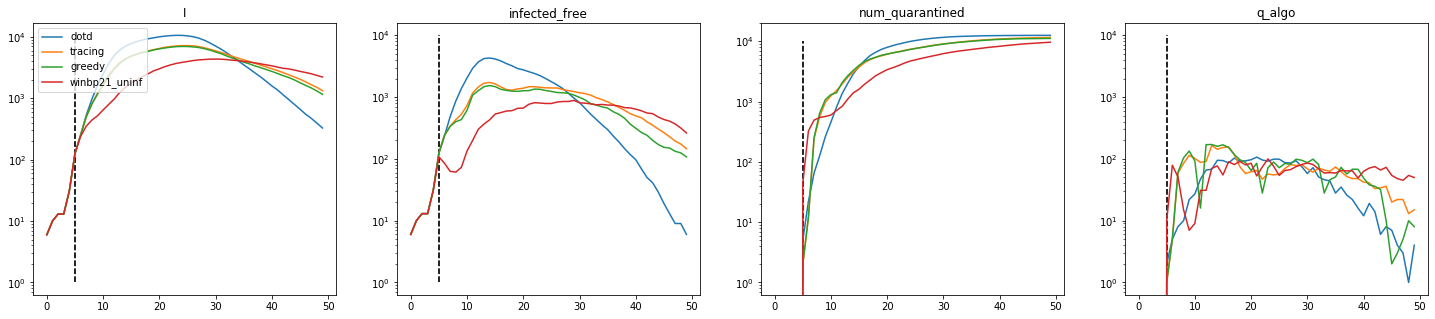

In [54]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,4,figsize = (25,5))
to_plot = ['I','infected_free','num_quarantined', "q_algo"]
for s in ress.keys():    
    for il,l in enumerate(to_plot):
        if s != "no_intervention":
            axs[il].plot(range(T),ress[s][l],label = s)
            if l!= "aurI":
                axs[il].set_yscale ("log") 
                axs[il].vlines(initial_steps,ymin = 1,ymax = 10**4,linestyle = "--",alpha = 0.5, color = "black")
            else:
                axs[il].vlines(initial_steps,ymin = 0,ymax = 1,linestyle = "--",alpha = 0.5, color = "black")
            
            axs[il].set_title(l,fontsize = 12)
    axs[0].legend(loc = 'upper left')
    
#fig.suptitle(f"num test algo {num_test_algo} - adoption_fraction {adoption_fraction}")
fig.show()
